In [1]:
#We want to define our pipeline of doing two-step distillation
#We first train our U-Net to predict the 32x32 output of cellpose
#Then we train our U-Net to predict the cellprob

#In here, I also want to add the cropping of the images to 256x256, later on we will want to make this process automatic
#I also want to add the IoU calculations during the second step of the training and print at each epoch

In [2]:
#Imports

from import_images import getImages
from import_model import get_cellpose_model
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
#images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
#directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    #output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    #upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [4]:
unet = UNet(encChannels=(1,16,32),decChannels=(32,16),nbClasses=1)

x = images_torch[0]
x = x.unsqueeze(0)
x = x.unsqueeze(0)
encFeatures, decFeatures, map = unet(x)

print(map.shape)

torch.Size([1, 1, 1024, 1024])


In [5]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])


In [6]:
print(cp_downsamples[0].shape,cp_upsamples[0].shape,cp_outputs[0].shape)

torch.Size([64, 512, 512]) (32, 1024, 1024) (1024, 1024)


In [7]:
unet = UNet(encChannels=(1,32,64,128, 256),decChannels=(256, 128,64,32),nbClasses=1)

#make a random torch array and input into the unet so that we can print the output shapes
x = torch.rand(1,1,256,256)
encFeatures, decFeatures, map = unet(x)
print(encFeatures[0].shape,decFeatures[0].shape,map.shape)

torch.Size([1, 32, 256, 256]) torch.Size([32, 256, 256]) torch.Size([1, 1, 256, 256])


In [8]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob


In [9]:
import torchvision.transforms as T

train_images, test_images, train_downsamples, test_downsamples, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_downsamples, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)

images_torch_rotated = []
for image in train_images:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)
print(1)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))
print(2)

cp_downsamples_rotated = []
for downsample in train_downsamples:
    cp_downsamples_rotated.append(downsample)
    for i in range(3):
        downsample = torch.rot90(downsample, 1, [1, 2])
        cp_downsamples_rotated.append(downsample)
print(3)

cp_downsamples_rotated_flipped = []
for upsample in cp_downsamples_rotated:
    cp_downsamples_rotated_flipped.append(upsample)
    cp_downsamples_rotated_flipped.append(torch.flip(upsample, [2]))
print(4)

cp_upsamples_rotated = []
for upsample in train_upsamples:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = np.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)
print(5)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(np.flip(upsample, [2]))
print(6)

cp_outputs_rotated = []
for output in train_cellprob:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = np.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)
print(7)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(np.flip(output, [1]))
print(8)

1
2
3
4
5
6
7
8


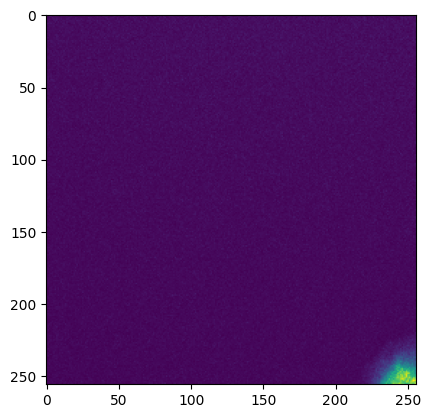

(1024, 1024)


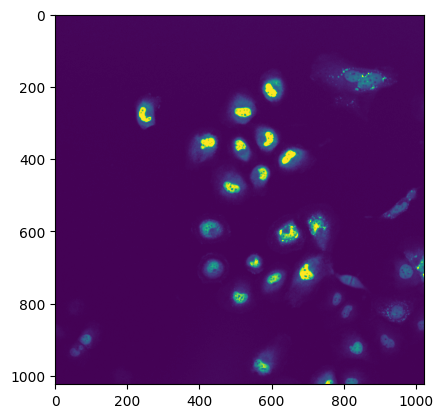

In [10]:
def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

def reconstruct_image(crops, size):
    assert len(crops) > 0

    image_size = 1024
    size = 256
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    crop_idx = 0
    for i in range(0, image_size, size):
        for j in range(0, image_size, size):
            image[i:i+size, j:j+size] = crops[crop_idx]
            crop_idx += 1

    return image

crops = get_crops(images[0],256)
plt.imshow(crops[0]); plt.show()
r_img = reconstruct_image(crops,images[0].shape[0])
print(r_img.shape)
plt.imshow(r_img)

In [18]:
#TODO: add a function to take an image with 32 channels and return an array with the same number of channels but with each channel being a crop of the original image


def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

#plots the crops as a grid
def plot_grid(crops):
    fig, axs = plt.subplots(4, 4, figsize=(10,10))
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(crops[i*4+j])
            axs[i,j].axis('off')
    plt.show()

images_cropped = []
for image in images_torch_rotated_flipped:
    crops = get_crops(image,256)
    for crop in crops:
        crop = crop.copy()
        images_cropped.append(crop)

cp_upsampled_cropped = []
for (i,upsample) in enumerate(cp_upsamples_rotated_flipped):
    print(i)
    crops_per_chan = []
    for chan in upsample:
        crops = get_crops(chan,256)
        crops_per_chan.append(crops)

    for j in range(16):
        crop_channels_of_crop = []
        for k in range(32):
           crop_channels_of_crop.append(crops_per_chan[k][j])
        crop_channels_of_crop = np.array(crop_channels_of_crop)
        crop_channels_of_crop = crop_channels_of_crop.copy()
        crop_channels_of_crop = torch.from_numpy(crop_channels_of_crop)
        cp_upsampled_cropped.append(crop_channels_of_crop)

cp_outputs_cropped = []
for output in cp_outputs_rotated_flipped:
    crops = get_crops(output,256)
    for crop in crops:
        crop = crop.copy()
        cp_outputs_cropped.append(crop)

AttributeError: 'Tensor' object has no attribute 'copy'

In [12]:
train_dataset = ImageDataset(images_cropped, cp_upsampled_cropped, cp_outputs_cropped)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [13]:
import torchvision.transforms as T

class LF_one(torch.nn.Module):
    def __init__(self):
        super(LF_one, self).__init__()
    def forward(self, y_32_pred, y_32_true):
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())
        return y_32_loss
    
class LF_two(torch.nn.Module):
    def __init__(self):
        super(LF_two, self).__init__()
    def forward(self, y_3_pred, y_3_true):
        #transform = T.Resize(1024)
        #y_3_true = transform(y_3_true)

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        
        y_3_loss = F.binary_cross_entropy(y_3_pred, y_3_true.float())
    
        y_3_pred = y_3_pred.view(-1)
        y_3_true = y_3_true.view(-1)
        intersection = (y_3_pred * y_3_true).sum()
        total = (y_3_pred + y_3_true).sum()
        union = total - intersection 
        IoU_loss = 1 - (intersection + 1)/(union + 1)

        #print(y_3_loss, IoU_loss)
        return y_3_loss * 0.5 + IoU_loss * 0.5
    
class LF_three(torch.nn.Module):
    def __init__(self):
        super(LF_three, self).__init__()
    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        y_3_loss = F.mse_loss(y_3_pred, y_3_true.float())

        #print(y_32_loss, y_3_loss)

        return y_32_loss * 0.5 + y_3_loss * 0.5
    
class reg_con(torch.nn.Module):
    def __init__(self):
        super(reg_con, self).__init__()

    def forward(self, y_32_pred, y_32_true, y_3_true):
        #y_32_pred = F.sigmoid(y_32_pred)
        #y_32_true = F.sigmoid(y_32_true)

        #gt = F.sigmoid(y_3_true)
        #gt = torch.where(gt > 0.5, torch.ones_like(gt), torch.zeros_like(gt))

        #region_affinity_distillation = self.region_affinity_distillation(y_32_pred, y_32_true, gt)
        #transform = T.Resize(1024)
        #y_3_true = transform(y_3_true)
        y_32_pred_s = F.sigmoid(y_32_pred)
        y_32_true_s = F.sigmoid(y_32_true)
        y_3_loss = F.binary_cross_entropy(y_32_pred_s, y_32_true_s.float())

        c = self.contrast_loss(y_32_pred, y_32_true)
        return c * 0.5 + y_3_loss * 0.5
    
    def region_contrast(self, x, gt):
        """
        calculate region contrast value
        :param x: feature
        :param gt: mask
        :return: value
        """
        smooth = 1.0
        mask0 = (gt == 0)
        mask1 = (gt == 1)

        region0 = torch.sum(x * mask0, dim=(2, 3)) / torch.sum(mask0, dim=(2, 3))
        region1 = torch.sum(x * mask1, dim=(2, 3)) / (torch.sum(mask1, dim=(2, 3)) + smooth)
        return F.cosine_similarity(region0, region1, dim=1)
    
    def region_affinity_distillation(self, s, t, gt):
        """
        region affinity distillation KD loss
        :param s: student feature
        :param t: teacher feature
        :return: loss value
        """

        #
        gt = torch.unsqueeze(gt, 1)

        gt = F.interpolate(gt, s.size()[1:])

        #print(s.shape, t.shape, gt.shape)

        return (self.region_contrast(s, gt) - self.region_contrast(t, gt)).pow(2).mean()
    
    def contrast_loss(self, x, gt):
        #let's calculate the class difference

        #get the groundtruth mask
        gt_mask = gt
        gt_mask = gt_mask > 0.5

        #get the groundtruth cellprob
        gt_cp = gt
        gt_cp = F.sigmoid(gt_cp)

        #get all the gt_cp values that are 1
        gt_cp_0 = gt_cp[gt_mask == 0]
        gt_cp_1 = gt_cp[gt_mask == 1]

        #get the mean value of gt_cp_0
        gt_cp_0_mean = gt_cp_0.mean()
        gt_cp_1_mean = gt_cp_1.mean()

        pred = x
        pred = pred.unsqueeze(1)
        #print(pred.shape)
        #pred = F.interpolate(pred, (512,512))
        #print(pred.shape)
        #sigmoid the pred
        pred = F.sigmoid(pred)
        gt_mask = gt_mask.unsqueeze(1)
        pred_0 = pred[gt_mask == 0]
        pred_1 = pred[gt_mask == 1]
        pred_0_mean = pred_0.mean()
        pred_1_mean = pred_1.mean()

        #absolute difference between the contrasts
        return abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean)

In [14]:
def trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler, epoch_num, step, device):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, upsample, cp_output in train_loader:
        #cast to float32
        image = image.float()
        upsample = upsample.float()
        cp_output = cp_output.float()
        (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)
        
        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)
        
        if step == 1:
            #transform = T.Resize(512)
            #y_32_pred = transform(y_32_pred)
            loss = loss_fn(y_32_pred,  upsample) # calculate the loss of that prediction
            #loss = loss_fn(y_32_pred, upsample, cp_output)
        elif step == 2:
            if 4 == 5:
                kl_loss = torch.nn.KLDivLoss(reduction="mean")
                transform = T.Resize(1024)
                cp_output_t = transform(cp_output)

                y_3_pred = F.sigmoid(y_3_pred)
                #cp_output_t = F.sigmoid(cp_output_t)

                loss = kl_loss(y_3_pred.double().log(), cp_output_t.double().log())
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #print(y_3_pred.shape, cp_output.shape)
            loss = loss_fn(y_3_pred, cp_output)
            #transform = T.Resize(1024)
            #cp_output_t = transform(cp_output)
            #cp_output_t_bin = torch.where(cp_output_t > 0.5,
                                      #torch.ones_like(cp_output_t),
                                      #torch.zeros_like(cp_output_t))
            #loss = loss_fn(y_3_pred, cp_output_t)
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #loss = loss_fn(y_3_pred,  cp_output)
        elif step == 3:
            loss = loss_fn(y_32_pred,  upsample, y_3_pred, cp_output) # calculate the loss of that prediction
            

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if step == 2 or step == 3:
        iou_score = 0
        for image, upsample, cp_output in test_loader:
            image = image.float()
            donwsample_cp = donwsample_cp.float()
            upsample = upsample.float()
            cp_output = cp_output.float()
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)

            image_crops = get_crops(image.squeeze(),256)
            y_3_pred = []
            for crop in image_crops:
                crop = crop.unsqueeze(0)
                crop = crop.unsqueeze(0)
                y_16_pred, y_32_pred, pred = unet(crop)
                pred = pred.squeeze()
                y_3_pred.append(pred.cpu().detach().numpy().tolist())

            y_3_pred = reconstruct_image(y_3_pred,256)

            #y_16_pred, y_32_pred, y_3_pred = unet(image)
            
            #y_32_pred = y_32_pred.squeeze(1)
            #y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = 1/(1+np.exp(-y_3_pred))
            #y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            #transform = T.Resize(1024)
            #cp_output = transform(cp_output)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)

            intersection = np.logical_and(cp_output, y_3_pred)
            union = np.logical_or(cp_output, y_3_pred)
            iou_score += np.sum(intersection) / np.sum(union)

        for image, upsample, cp_output in test_loader:
            
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)
            
            if epoch_num % 10 == 0:
                plt.subplot(1,4,1)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,2)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,3)
                plt.imshow(cp_output)
                plt.subplot(1,4,4)
                plt.imshow(cp_output)
                plt.show()
            
            break


        iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        if step == 1:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
        elif step == 2:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)
        elif step == 3:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [15]:
def trainEpoch_new(unet, train_loader, test_loader, first_loss_fn, second_loss_fn, optimiser, scheduler, epoch_num, device):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, donwsample_cp, upsample, cp_output in train_loader:

        image = image.float()
        donwsample_cp = donwsample_cp.float()
        upsample = upsample.float()
        cp_output = cp_output.float()
        (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device))
        
        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)

        loss = first_loss_fn(y_32_pred,  upsample) # calculate the loss of that prediction

        loss += second_loss_fn(y_3_pred, cp_output)

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters

        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    iou_score = 0
    for image, donwsample_cp, upsample, cp_output in test_loader:
        
        (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device))

        image = image.unsqueeze(1)

        image_crops = get_crops(image.squeeze(),256)
        y_3_pred = []
        for crop in image_crops:
            crop = crop.unsqueeze(0)
            crop = crop.unsqueeze(0)
            y_16_pred, y_32_pred, pred = unet(crop)
            pred = pred.squeeze()
            y_3_pred.append(pred.cpu().detach().numpy().tolist())

        y_3_pred = reconstruct_image(y_3_pred,256)
        
        y_3_pred = 1 / (1 + np.exp(-y_3_pred))
        y_3_pred = np.array(y_3_pred)
        y_3_pred = np.squeeze(y_3_pred)
        y_3_pred = y_3_pred > 0.5
        y_3_pred = y_3_pred.astype(int)

        cp_output = cp_output.cpu().detach().numpy().tolist()
        cp_output = np.array(cp_output)
        cp_output = np.squeeze(cp_output)
        cp_output = cp_output > 0.5
        cp_output = cp_output.astype(int)

        intersection = np.logical_and(cp_output, y_3_pred)
        union = np.logical_or(cp_output, y_3_pred)
        iou_score += np.sum(intersection) / np.sum(union)

    for image, donwsample_cp, upsample, cp_output in test_loader:
        
        (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device))

        image = image.unsqueeze(1)

        image_crops = get_crops(image.squeeze(),256)
        y_3_pred = []
        for crop in image_crops:
            crop = crop.unsqueeze(0)
            crop = crop.unsqueeze(0)
            y_16_pred, y_32_pred, pred = unet(crop)
            pred = pred.squeeze()
            y_3_pred.append(pred.cpu().detach().numpy().tolist())

        y_3_pred = reconstruct_image(y_3_pred,256)
        
        y_3_pred = 1 / (1 + np.exp(-y_3_pred))
        y_3_pred = np.array(y_3_pred)
        y_3_pred = np.squeeze(y_3_pred)
        y_3_pred = y_3_pred > 0.5
        y_3_pred = y_3_pred.astype(int)

        cp_output = cp_output.cpu().detach().numpy().tolist()
        cp_output = np.array(cp_output)
        cp_output = np.squeeze(cp_output)
        cp_output = cp_output > 0.5
        cp_output = cp_output.astype(int)
        
        if epoch_num % 10 == 0:
            plt.subplot(1,4,1)
            plt.imshow(y_3_pred)
            plt.subplot(1,4,2)
            plt.imshow(y_3_pred)
            plt.subplot(1,4,3)
            plt.imshow(cp_output)
            plt.subplot(1,4,4,)
            plt.imshow(cp_output)
            plt.show()
        
        break

    iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [16]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')

In [17]:
#TODO: add test loss here
first_loss_fn, second_loss_fn, third_loss_fn = LF_one(), LF_two(), LF_three()
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.000001, max_lr=1)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, third_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=3)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

In [ ]:
#random torch of 256 by 256
r_t = torch.rand(1, 1, 256,256)
pred = unet(r_t.to('cuda:0'))
print(len(pred[0]))
print(pred[1].shape)
print(pred[2].shape)

4
torch.Size([1, 32, 256, 256])
torch.Size([1, 1, 256, 256])


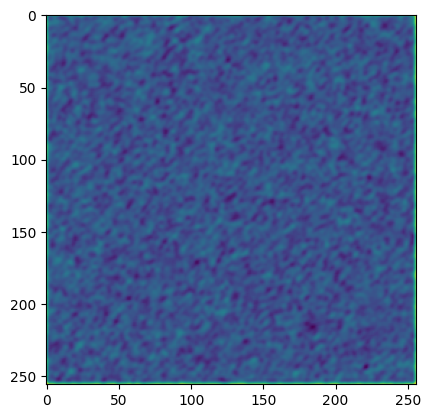

In [ ]:
plt.imshow(pred[2].squeeze().cpu().detach().numpy())

4
torch.Size([1, 32, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 64, 512, 512])
torch.Size([1, 32, 256, 256])
torch.Size([1, 256, 256])


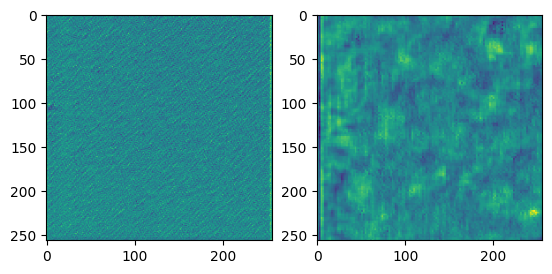

In [ ]:
for image, upsample, cp_output in train_loader:

    pred = unet(image.unsqueeze(1).to('cuda:0'))
    print(len(pred[0]))
    print(pred[1].shape)
    print(pred[2].shape)

    print(image.shape)
    print(donwsample_cp.shape)
    print(upsample.shape)
    print(cp_output.shape)

    plt.subplot(1,2,1)
    plt.imshow(pred[2].squeeze().cpu().detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(cp_output.squeeze().cpu().detach().numpy())
    plt.show()

    break

In [ ]:
print(pred[2])

tensor([[[[-1.3381, -3.4076, -3.1899,  ..., -0.2318, -0.2250, -0.1940],
          [-1.8844, -4.4438, -1.8666,  ..., -0.2073, -0.2272, -0.1969],
          [-2.9243, -3.4904,  0.1748,  ..., -0.1579, -0.1921, -0.1833],
          ...,
          [-0.1938, -0.2015, -0.1322,  ..., -0.2058, -0.1880, -0.1445],
          [-0.1982, -0.1508, -0.1451,  ..., -0.1992, -0.0942, -0.1347],
          [-0.1708, -0.1834, -0.1567,  ..., -0.1614, -0.1236, -0.1578]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


In [ ]:
print(cp_output)

tensor([[[  5.3728,   5.3728,   9.6571,  ..., -11.6050, -11.6050, -11.0470],
         [  5.3728,   5.3728,   9.6571,  ..., -11.6050, -11.6050, -11.0470],
         [  4.2484,   4.2484,   8.6444,  ..., -11.8834, -11.8834, -11.3346],
         ...,
         [ -8.4175,  -8.4175,  -8.4327,  ...,  -8.2891,  -8.2891,  -8.3930],
         [ -8.4175,  -8.4175,  -8.4327,  ...,  -8.2891,  -8.2891,  -8.3930],
         [ -8.4012,  -8.4012,  -8.4690,  ...,  -8.3328,  -8.3328,  -8.3962]]],
       dtype=torch.float64)


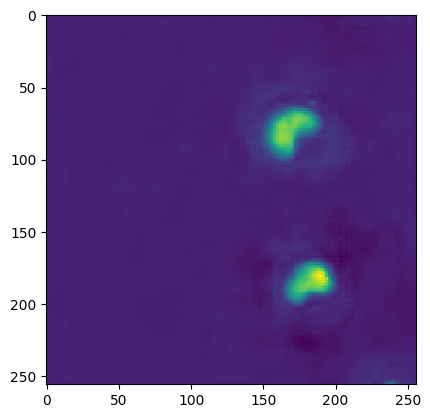

In [ ]:
plt.imshow(cp_output.squeeze().cpu().detach().numpy())

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\rz200\AppData\Local\Temp\ipykernel_19172\2565813840.py:86: RuntimeWarning: overflow encountered in exp
  y_3_pred = 1/(1+np.exp(-y_3_pred))


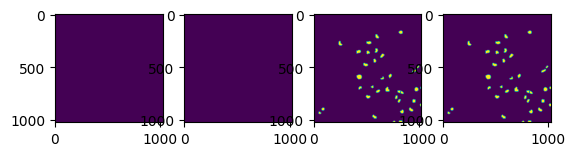

Epoch  0 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.677206039428711
Epoch  1 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.3031220436096191
Epoch  2 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2804996967315674
Epoch  3 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2800288200378418
Epoch  4 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2841618061065674
Epoch  5 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2873358726501465
Epoch  6 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.273005723953247
Epoch  7 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.300858497619629
Epoch  8 Training loss:  1.4301403045654297 IoU score:  0.0 Time:  1.2720935344696045
Epoch  9 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.3699951171875


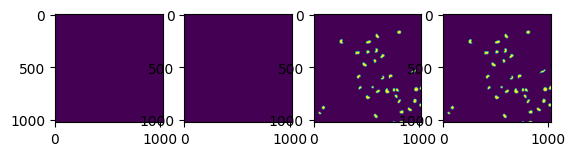

Epoch  10 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.5125281810760498
Epoch  11 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2360138893127441
Epoch  12 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2538678646087646
Epoch  13 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2272262573242188
Epoch  14 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2523179054260254
Epoch  15 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.2265841960906982
Epoch  16 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.243363618850708
Epoch  17 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2404303550720215
Epoch  18 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2220430374145508
Epoch  19 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.26503586769104


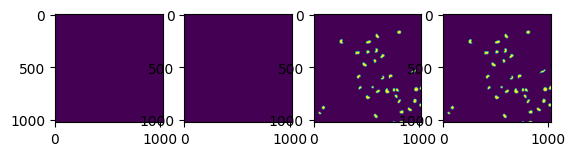

Epoch  20 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.557391881942749
Epoch  21 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.2866103649139404
Epoch  22 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.3223323822021484
Epoch  23 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.3086521625518799
Epoch  24 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.2997734546661377
Epoch  25 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.3015542030334473
Epoch  26 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.304030179977417
Epoch  27 Training loss:  1.4301401138305665 IoU score:  0.0 Time:  1.3245298862457275
Epoch  28 Training loss:  1.430140209197998 IoU score:  0.0 Time:  1.4058098793029785


KeyboardInterrupt: 

In [ ]:
first_loss_fn, second_loss_fn = LF_one(), LF_two()
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.001, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.000001, max_lr=0.001)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, second_loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch,device='cuda:0',step=2)

In [ ]:
#TODO: add test loss here
step = 1
loss_fn = LF_one()
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=1)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step,device='cuda:0')

Epoch  0 Training loss:  0.081350439786911 Time:  0.6676540374755859
Epoch  1 Training loss:  0.0516090989112854 Time:  0.46210718154907227
Epoch  2 Training loss:  0.02433699518442154 Time:  0.45673441886901855
Epoch  3 Training loss:  0.018981778621673585 Time:  0.4936671257019043
Epoch  4 Training loss:  0.017754261195659638 Time:  0.4610152244567871
Epoch  5 Training loss:  0.017203086614608766 Time:  0.4595203399658203
Epoch  6 Training loss:  0.016712276637554167 Time:  0.45652174949645996
Epoch  7 Training loss:  0.017137475311756134 Time:  0.4606935977935791
Epoch  8 Training loss:  0.016650767624378206 Time:  0.4796419143676758
Epoch  9 Training loss:  0.017010702192783354 Time:  0.458026647567749
Epoch  10 Training loss:  0.017592625319957735 Time:  0.4648559093475342
Epoch  11 Training loss:  0.017609578371047974 Time:  0.46157217025756836
Epoch  12 Training loss:  0.01651013791561127 Time:  0.4719514846801758
Epoch  13 Training loss:  0.016022799909114836 Time:  0.462335586

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

15969

In [ ]:
#Ok so I'm designing an experiment where we try to see if different manual seeds give a better result
#After having done the first training step, I give random weight initialisations to the head of the U-Net and then train it

#I first need to save the current model's weights as that is the base model we'll keep using to then train the head

In [ ]:
torch.save(unet.state_dict(), "/Users/av337/Documents/developmentRehan/distillCellSegTrack/pipeline/base_model")

In [ ]:


unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('mps')
unet.load_state_dict(torch.load("/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/base_model"))
unet.encoder.requires_grad_ = False
unet.decoder.requires_grad_ = False
torch.manual_seed(3)
unet.head.weight = torch.nn.Parameter(torch.rand(unet.head.weight.shape))
print(unet.head.weight)

Parameter containing:
tensor([[[[0.0043]],

         [[0.1056]],

         [[0.2858]],

         [[0.0270]],

         [[0.4716]],

         [[0.0601]],

         [[0.7719]],

         [[0.7437]],

         [[0.5944]],

         [[0.8879]],

         [[0.4510]],

         [[0.7995]],

         [[0.1498]],

         [[0.4015]],

         [[0.0542]],

         [[0.4594]],

         [[0.1756]],

         [[0.9492]],

         [[0.8473]],

         [[0.8749]],

         [[0.6483]],

         [[0.2148]],

         [[0.9493]],

         [[0.0121]],

         [[0.1809]],

         [[0.1877]],

         [[0.2927]],

         [[0.5997]],

         [[0.1213]],

         [[0.1148]],

         [[0.2609]],

         [[0.8052]]]], requires_grad=True)


Seed: 0


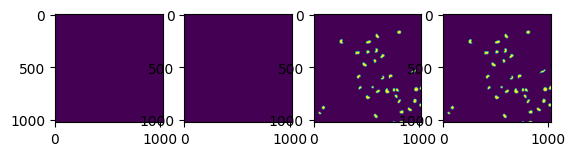

Epoch  0 Training loss:  1.1343430519104003 IoU score:  0.0 Time:  1.5356042385101318
Epoch  1 Training loss:  1.124394130706787 IoU score:  0.0 Time:  1.2543303966522217
Epoch  2 Training loss:  1.1009798049926758 IoU score:  0.0 Time:  1.3247509002685547
Epoch  3 Training loss:  1.0678625106811523 IoU score:  0.0 Time:  1.3359825611114502
Epoch  4 Training loss:  1.0447205543518066 IoU score:  0.0 Time:  1.339756965637207
Epoch  5 Training loss:  1.0150416374206543 IoU score:  0.0 Time:  1.3354926109313965
Epoch  6 Training loss:  0.9766322135925293 IoU score:  0.0 Time:  1.35689115524292
Epoch  7 Training loss:  0.942265510559082 IoU score:  0.0 Time:  1.3394691944122314
Epoch  8 Training loss:  0.9014772415161133 IoU score:  0.0 Time:  1.3380227088928223
Epoch  9 Training loss:  0.8641748428344727 IoU score:  0.0 Time:  1.338022232055664


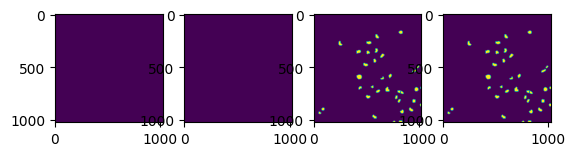

Epoch  10 Training loss:  0.8145594596862793 IoU score:  0.0 Time:  1.6242177486419678
Epoch  11 Training loss:  0.742136812210083 IoU score:  0.0 Time:  1.3563432693481445
Epoch  12 Training loss:  0.6530455112457275 IoU score:  0.0 Time:  1.3451733589172363
Epoch  13 Training loss:  0.5535455703735351 IoU score:  0.0 Time:  1.346876859664917
Epoch  14 Training loss:  0.4843443870544434 IoU score:  0.0 Time:  1.3503332138061523
Epoch  15 Training loss:  0.46626620292663573 IoU score:  1.852537977028529e-05 Time:  1.351928949356079
Epoch  16 Training loss:  0.45749359130859374 IoU score:  3.704938683264792e-05 Time:  1.3339166641235352
Epoch  17 Training loss:  0.4517021179199219 IoU score:  0.00024358052165885887 Time:  1.342801570892334
Epoch  18 Training loss:  0.44420485496520995 IoU score:  0.000936176340061848 Time:  1.3298118114471436
Epoch  19 Training loss:  0.4385825634002686 IoU score:  0.004162079491043229 Time:  1.3087842464447021


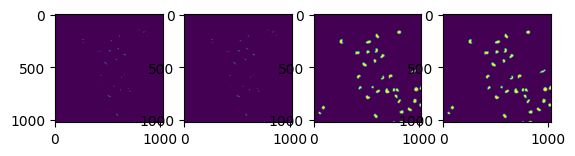

Epoch  20 Training loss:  0.43139352798461916 IoU score:  0.017393658548566976 Time:  1.7239494323730469
Epoch  21 Training loss:  0.42297024726867677 IoU score:  0.04421555993428611 Time:  1.3850557804107666
Epoch  22 Training loss:  0.40423808097839353 IoU score:  0.11582498781592512 Time:  1.3575677871704102
Epoch  23 Training loss:  0.35825767517089846 IoU score:  0.555150116312723 Time:  1.242522954940796
Epoch  24 Training loss:  0.295971941947937 IoU score:  0.5541980152452061 Time:  1.283069372177124
Epoch  25 Training loss:  0.3288136005401611 IoU score:  0.5396421366770896 Time:  1.2081096172332764
Epoch  26 Training loss:  0.3494837284088135 IoU score:  0.5243038913473324 Time:  1.218224287033081
Epoch  27 Training loss:  0.2849139213562012 IoU score:  0.6092438389455497 Time:  1.2522733211517334
Epoch  28 Training loss:  0.2818481922149658 IoU score:  0.6088881074866181 Time:  1.2671301364898682
Epoch  29 Training loss:  0.305894660949707 IoU score:  0.5328246223980725 Time

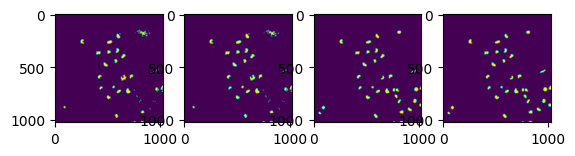

Epoch  30 Training loss:  0.2947981834411621 IoU score:  0.5869613392800864 Time:  1.5173556804656982
Epoch  31 Training loss:  0.2833439588546753 IoU score:  0.5962103106584202 Time:  1.313924789428711
Epoch  32 Training loss:  0.2664549112319946 IoU score:  0.5968216144024137 Time:  1.2378969192504883
Epoch  33 Training loss:  0.25841894149780276 IoU score:  0.5821990186484278 Time:  1.2178473472595215
Epoch  34 Training loss:  0.2491164207458496 IoU score:  0.6121142666305495 Time:  1.2309350967407227
Epoch  35 Training loss:  0.2361220359802246 IoU score:  0.6367633545823415 Time:  1.2517170906066895
Epoch  36 Training loss:  0.26396181583404543 IoU score:  0.5865517221513852 Time:  1.2733778953552246
Epoch  37 Training loss:  0.24287676811218262 IoU score:  0.5989263921759598 Time:  1.2299139499664307
Epoch  38 Training loss:  0.2372291088104248 IoU score:  0.5609450727769856 Time:  1.217341423034668
Epoch  39 Training loss:  0.25315136909484864 IoU score:  0.5849371254607971 Time

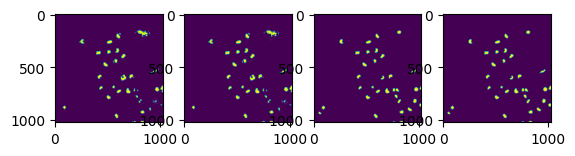

Epoch  40 Training loss:  0.25512802600860596 IoU score:  0.6484065231803451 Time:  1.504709243774414
Epoch  41 Training loss:  0.23130242824554442 IoU score:  0.6159834576090879 Time:  1.2294340133666992
Epoch  42 Training loss:  0.23556950092315673 IoU score:  0.5853029976846178 Time:  1.2679486274719238
Epoch  43 Training loss:  0.2286651611328125 IoU score:  0.5943849084791086 Time:  1.2637951374053955
Epoch  44 Training loss:  0.2234945297241211 IoU score:  0.5968291495449352 Time:  1.2550249099731445
Epoch  45 Training loss:  0.2209845542907715 IoU score:  0.6169742394509674 Time:  1.2668299674987793
Epoch  46 Training loss:  0.22550499439239502 IoU score:  0.6063462757203288 Time:  1.2735557556152344
Epoch  47 Training loss:  0.22097206115722656 IoU score:  0.5926906534945362 Time:  1.2464497089385986
Epoch  48 Training loss:  0.2183072090148926 IoU score:  0.62683516480478 Time:  1.2554676532745361
Epoch  49 Training loss:  0.2175426483154297 IoU score:  0.6419012535305646 Time

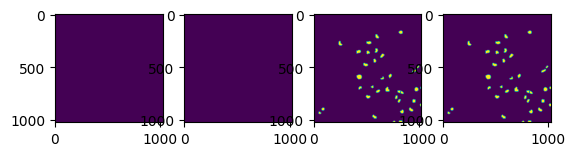

Epoch  0 Training loss:  1.2011598587036132 IoU score:  0.0 Time:  1.5910921096801758
Epoch  1 Training loss:  1.191329288482666 IoU score:  0.0 Time:  1.2560455799102783
Epoch  2 Training loss:  1.1732620239257812 IoU score:  0.0 Time:  1.2687404155731201
Epoch  3 Training loss:  1.1395397186279297 IoU score:  0.0 Time:  1.263484001159668
Epoch  4 Training loss:  1.1079318046569824 IoU score:  0.0 Time:  1.252573013305664
Epoch  5 Training loss:  1.0783103942871093 IoU score:  0.0 Time:  1.2651634216308594
Epoch  6 Training loss:  1.0368283271789551 IoU score:  0.0 Time:  1.2756071090698242
Epoch  7 Training loss:  0.9873218536376953 IoU score:  0.0 Time:  1.2629480361938477
Epoch  8 Training loss:  0.9505306243896484 IoU score:  0.0 Time:  1.3014609813690186
Epoch  9 Training loss:  0.9054368019104004 IoU score:  0.0 Time:  1.3207180500030518


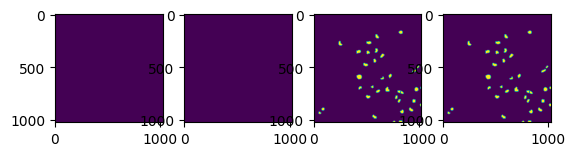

Epoch  10 Training loss:  0.8413398742675782 IoU score:  0.0 Time:  1.5555644035339355
Epoch  11 Training loss:  0.775438928604126 IoU score:  0.0 Time:  1.2133610248565674
Epoch  12 Training loss:  0.6776778221130371 IoU score:  0.0 Time:  1.2250325679779053
Epoch  13 Training loss:  0.5549521446228027 IoU score:  0.0 Time:  1.2633490562438965
Epoch  14 Training loss:  0.4961514949798584 IoU score:  0.0 Time:  1.2883594036102295
Epoch  15 Training loss:  0.4771984577178955 IoU score:  7.477172549009085e-05 Time:  1.1944139003753662
Epoch  16 Training loss:  0.4573978424072266 IoU score:  0.2936595966197124 Time:  1.238577127456665
Epoch  17 Training loss:  0.33847320079803467 IoU score:  0.5250742918561201 Time:  1.2807481288909912
Epoch  18 Training loss:  0.3284393072128296 IoU score:  0.4881389350114018 Time:  1.2810096740722656
Epoch  19 Training loss:  0.33544981479644775 IoU score:  0.5404734918931038 Time:  1.2163665294647217


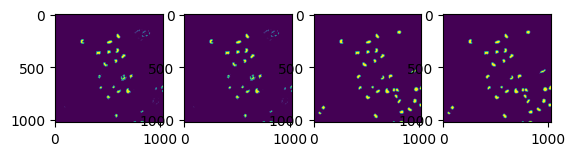

Epoch  20 Training loss:  0.3401465892791748 IoU score:  0.46376882196462965 Time:  1.5590667724609375
Epoch  21 Training loss:  0.2926387548446655 IoU score:  0.5584541067285078 Time:  1.1962659358978271
Epoch  22 Training loss:  0.2959124088287354 IoU score:  0.5286837932119102 Time:  1.2458851337432861
Epoch  23 Training loss:  0.30603828430175783 IoU score:  0.5662194964648769 Time:  1.2566206455230713
Epoch  24 Training loss:  0.27787702083587645 IoU score:  0.5764734718721205 Time:  1.2778706550598145
Epoch  25 Training loss:  0.2648782253265381 IoU score:  0.45815524675141056 Time:  1.2377712726593018
Epoch  26 Training loss:  0.30208697319030764 IoU score:  0.5884710265150782 Time:  1.2896995544433594
Epoch  27 Training loss:  0.26472747325897217 IoU score:  0.5075879894525834 Time:  1.2356688976287842
Epoch  28 Training loss:  0.30174546241760253 IoU score:  0.5970608941611394 Time:  1.2579290866851807
Epoch  29 Training loss:  0.2485835313796997 IoU score:  0.5952762430711495

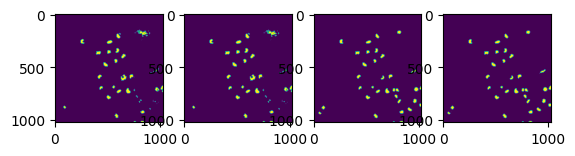

Epoch  30 Training loss:  0.24393467903137206 IoU score:  0.6139721386574368 Time:  1.5147078037261963
Epoch  31 Training loss:  0.24136052131652833 IoU score:  0.6137533893080711 Time:  1.2179317474365234
Epoch  32 Training loss:  0.23791880607604982 IoU score:  0.5808960608641947 Time:  1.2493584156036377
Epoch  33 Training loss:  0.24186370372772217 IoU score:  0.5973104653768049 Time:  1.2860515117645264
Epoch  34 Training loss:  0.2500253438949585 IoU score:  0.6296693076488891 Time:  1.2536792755126953
Epoch  35 Training loss:  0.27965431213378905 IoU score:  0.5345875835794328 Time:  1.2905900478363037
Epoch  36 Training loss:  0.2514859437942505 IoU score:  0.6347878301293493 Time:  1.313425064086914
Epoch  37 Training loss:  0.228289794921875 IoU score:  0.6319708659792445 Time:  1.2959067821502686
Epoch  38 Training loss:  0.23609685897827148 IoU score:  0.5028252287768771 Time:  1.3130366802215576
Epoch  39 Training loss:  0.24888334274291993 IoU score:  0.6288329541676692 T

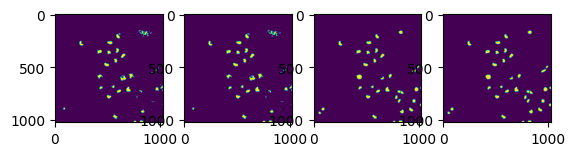

Epoch  40 Training loss:  0.26346282958984374 IoU score:  0.5952612367910942 Time:  1.5965473651885986
Epoch  41 Training loss:  0.23352792263031005 IoU score:  0.5955301302457663 Time:  1.3011937141418457
Epoch  42 Training loss:  0.2291386604309082 IoU score:  0.6267598639881709 Time:  1.305537223815918
Epoch  43 Training loss:  0.22702491283416748 IoU score:  0.5778387555081099 Time:  1.3222532272338867
Epoch  44 Training loss:  0.21861114501953124 IoU score:  0.6440098364856843 Time:  1.3012173175811768
Epoch  45 Training loss:  0.23498172760009767 IoU score:  0.5722652529047554 Time:  1.3081932067871094
Epoch  46 Training loss:  0.2216857671737671 IoU score:  0.5995293033390856 Time:  1.2980749607086182
Epoch  47 Training loss:  0.2176043748855591 IoU score:  0.6502820448984218 Time:  1.2558643817901611
Epoch  48 Training loss:  0.2303286075592041 IoU score:  0.5825886203184651 Time:  1.3185946941375732
Epoch  49 Training loss:  0.2484898090362549 IoU score:  0.6106381363013159 Ti

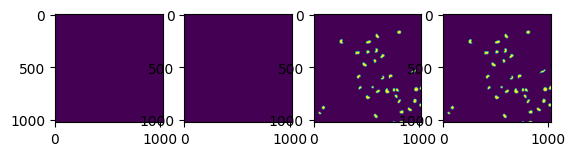

Epoch  0 Training loss:  1.0263894081115723 IoU score:  0.0 Time:  1.5643932819366455
Epoch  1 Training loss:  1.0161042213439941 IoU score:  0.0 Time:  1.3076999187469482
Epoch  2 Training loss:  0.9986590385437012 IoU score:  0.0 Time:  1.3274683952331543
Epoch  3 Training loss:  0.9705059051513671 IoU score:  0.0 Time:  1.289097785949707
Epoch  4 Training loss:  0.9443572998046875 IoU score:  0.0 Time:  1.176126480102539
Epoch  5 Training loss:  0.909921932220459 IoU score:  0.0 Time:  1.1992251873016357
Epoch  6 Training loss:  0.8839280128479003 IoU score:  0.0 Time:  1.1954596042633057
Epoch  7 Training loss:  0.832705307006836 IoU score:  0.0 Time:  1.2107350826263428
Epoch  8 Training loss:  0.7866838455200196 IoU score:  0.0 Time:  1.218029499053955
Epoch  9 Training loss:  0.7190934181213379 IoU score:  0.0 Time:  1.2019908428192139


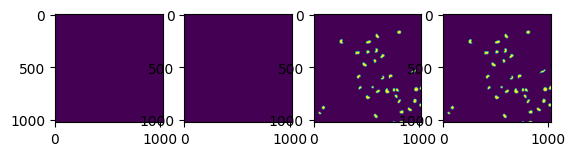

Epoch  10 Training loss:  0.6451139926910401 IoU score:  0.0 Time:  1.4858729839324951
Epoch  11 Training loss:  0.5768769264221192 IoU score:  0.0 Time:  1.1940088272094727
Epoch  12 Training loss:  0.5008899688720703 IoU score:  0.002018887448984756 Time:  1.2074103355407715
Epoch  13 Training loss:  0.45445685386657714 IoU score:  0.20405494732696372 Time:  1.2331936359405518
Epoch  14 Training loss:  0.35913944244384766 IoU score:  0.5069824080507779 Time:  1.2021894454956055
Epoch  15 Training loss:  0.302292013168335 IoU score:  0.5608060073765533 Time:  1.3698217868804932
Epoch  16 Training loss:  0.2949678897857666 IoU score:  0.42902424533699507 Time:  1.2897274494171143
Epoch  17 Training loss:  0.3147329092025757 IoU score:  0.3836128143128316 Time:  1.2762181758880615
Epoch  18 Training loss:  0.37980568408966064 IoU score:  0.5148627282001326 Time:  1.3228633403778076
Epoch  19 Training loss:  0.33887386322021484 IoU score:  0.4937120145512912 Time:  1.3076748847961426


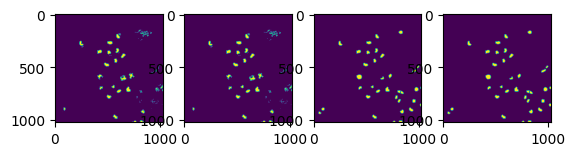

Epoch  20 Training loss:  0.2806314706802368 IoU score:  0.576804563549824 Time:  1.5882725715637207
Epoch  21 Training loss:  0.258378791809082 IoU score:  0.5903339479289856 Time:  1.3101530075073242
Epoch  22 Training loss:  0.2438426971435547 IoU score:  0.6283842210216872 Time:  1.3015413284301758
Epoch  23 Training loss:  0.23909473419189453 IoU score:  0.5835081662644988 Time:  1.3237388134002686
Epoch  24 Training loss:  0.23612680435180664 IoU score:  0.6214845479219583 Time:  1.3620951175689697
Epoch  25 Training loss:  0.2715088605880737 IoU score:  0.5450764642920757 Time:  1.3741588592529297
Epoch  26 Training loss:  0.2768594741821289 IoU score:  0.6031323720827113 Time:  1.3347580432891846
Epoch  27 Training loss:  0.2687441110610962 IoU score:  0.60296053290682 Time:  1.3303322792053223
Epoch  28 Training loss:  0.23543093204498292 IoU score:  0.6208764973596377 Time:  1.335759162902832
Epoch  29 Training loss:  0.227997350692749 IoU score:  0.6248336344251411 Time:  1.

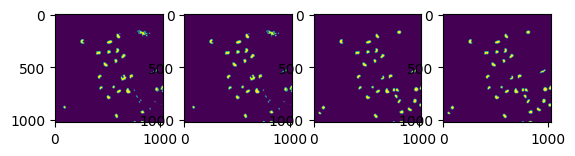

Epoch  30 Training loss:  0.22306432723999023 IoU score:  0.613717312865079 Time:  1.5969932079315186
Epoch  31 Training loss:  0.22652459144592285 IoU score:  0.6064483004191064 Time:  1.3406851291656494
Epoch  32 Training loss:  0.21945173740386964 IoU score:  0.5886351524209181 Time:  1.3102068901062012
Epoch  33 Training loss:  0.22570009231567384 IoU score:  0.5565680523058547 Time:  1.318099021911621
Epoch  34 Training loss:  0.24673826694488527 IoU score:  0.6402488664631323 Time:  1.3165271282196045
Epoch  35 Training loss:  0.2279695987701416 IoU score:  0.6000443246738508 Time:  1.3565192222595215
Epoch  36 Training loss:  0.2278167724609375 IoU score:  0.6005558339148371 Time:  1.3631510734558105
Epoch  37 Training loss:  0.2198613166809082 IoU score:  0.6383855337160269 Time:  1.3481061458587646
Epoch  38 Training loss:  0.22066469192504884 IoU score:  0.5939897590639989 Time:  1.332554817199707
Epoch  39 Training loss:  0.22126450538635253 IoU score:  0.5887009841053257 Ti

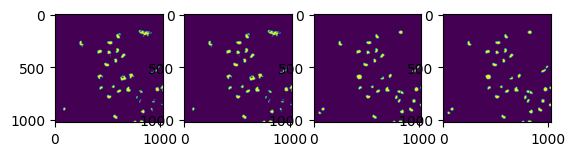

Epoch  40 Training loss:  0.21551244258880614 IoU score:  0.656617521736975 Time:  1.4901206493377686
Epoch  41 Training loss:  0.2266059398651123 IoU score:  0.6040176347369886 Time:  1.22420334815979
Epoch  42 Training loss:  0.2171332359313965 IoU score:  0.5985198817528405 Time:  1.235316276550293
Epoch  43 Training loss:  0.21474409103393555 IoU score:  0.6569526131474722 Time:  1.2071435451507568
Epoch  44 Training loss:  0.21728761196136476 IoU score:  0.6364335146554848 Time:  1.2254447937011719
Epoch  45 Training loss:  0.2099858522415161 IoU score:  0.5916001715660666 Time:  1.204280138015747
Epoch  46 Training loss:  0.21070661544799804 IoU score:  0.5924188774480257 Time:  1.190803050994873
Epoch  47 Training loss:  0.21380293369293213 IoU score:  0.6273723365164344 Time:  1.195995807647705
Epoch  48 Training loss:  0.2133622646331787 IoU score:  0.5979635314524808 Time:  1.2164306640625
Epoch  49 Training loss:  0.22304227352142333 IoU score:  0.6262031874303031 Time:  1.1

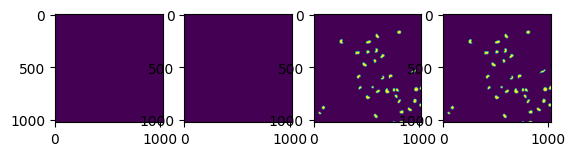

Epoch  0 Training loss:  1.0327793121337892 IoU score:  0.0 Time:  1.549567461013794
Epoch  1 Training loss:  1.0228239059448243 IoU score:  0.0 Time:  1.2032947540283203
Epoch  2 Training loss:  0.999257755279541 IoU score:  0.0 Time:  1.2309527397155762
Epoch  3 Training loss:  0.9750130653381348 IoU score:  0.0 Time:  1.2023310661315918
Epoch  4 Training loss:  0.9423282623291016 IoU score:  0.0 Time:  1.1919646263122559
Epoch  5 Training loss:  0.9040083885192871 IoU score:  0.0 Time:  1.2174434661865234
Epoch  6 Training loss:  0.870386791229248 IoU score:  0.0 Time:  1.2225539684295654
Epoch  7 Training loss:  0.8277647018432617 IoU score:  0.0 Time:  1.2473204135894775
Epoch  8 Training loss:  0.7867629051208496 IoU score:  0.0 Time:  1.1848223209381104
Epoch  9 Training loss:  0.7059286594390869 IoU score:  0.0 Time:  1.2065131664276123


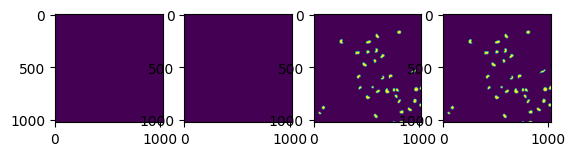

Epoch  10 Training loss:  0.6395514011383057 IoU score:  0.0 Time:  1.4833652973175049
Epoch  11 Training loss:  0.5706151008605957 IoU score:  0.0 Time:  1.2384250164031982
Epoch  12 Training loss:  0.5092760562896729 IoU score:  1.8871485185884127e-05 Time:  1.1801798343658447
Epoch  13 Training loss:  0.466156530380249 IoU score:  0.0002047531372442097 Time:  1.2065505981445312
Epoch  14 Training loss:  0.4549688816070557 IoU score:  0.000336389944769499 Time:  1.223254680633545
Epoch  15 Training loss:  0.44371738433837893 IoU score:  0.0012886940348080245 Time:  1.2305567264556885
Epoch  16 Training loss:  0.436738109588623 IoU score:  0.01777357920743666 Time:  1.2503962516784668
Epoch  17 Training loss:  0.3815634250640869 IoU score:  0.5445812774499451 Time:  1.1924970149993896
Epoch  18 Training loss:  0.3154017448425293 IoU score:  0.5497151012473898 Time:  1.2011439800262451
Epoch  19 Training loss:  0.3132049798965454 IoU score:  0.5667957850843217 Time:  1.2863259315490723

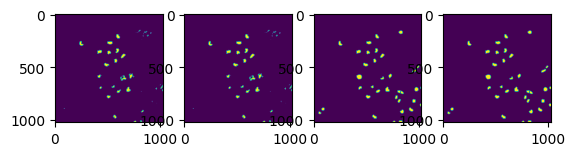

Epoch  20 Training loss:  0.2922221183776855 IoU score:  0.47382989933978076 Time:  1.5107173919677734
Epoch  21 Training loss:  0.3064246654510498 IoU score:  0.5643876507694296 Time:  1.205597162246704
Epoch  22 Training loss:  0.3049907207489014 IoU score:  0.49121408721970006 Time:  1.233865737915039
Epoch  23 Training loss:  0.2813992977142334 IoU score:  0.5648224530491115 Time:  1.2201042175292969
Epoch  24 Training loss:  0.33825371265411375 IoU score:  0.39607888560161725 Time:  1.1870596408843994
Epoch  25 Training loss:  0.30251522064208985 IoU score:  0.602753754692795 Time:  1.2481729984283447
Epoch  26 Training loss:  0.2813547134399414 IoU score:  0.590825520298897 Time:  1.2100830078125
Epoch  27 Training loss:  0.2550360679626465 IoU score:  0.565091837589497 Time:  1.2266333103179932
Epoch  28 Training loss:  0.2509605884552002 IoU score:  0.6265812298627377 Time:  1.217902660369873
Epoch  29 Training loss:  0.2577101707458496 IoU score:  0.49727191065621124 Time:  1.

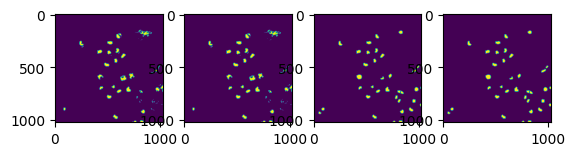

Epoch  30 Training loss:  0.27023770809173586 IoU score:  0.6091640485658582 Time:  1.4586529731750488
Epoch  31 Training loss:  0.25018503665924074 IoU score:  0.5751906534869352 Time:  1.253220558166504
Epoch  32 Training loss:  0.2480785846710205 IoU score:  0.5689164285137334 Time:  1.2052292823791504
Epoch  33 Training loss:  0.25030572414398194 IoU score:  0.6410374952488024 Time:  1.2817304134368896
Epoch  34 Training loss:  0.24908957481384278 IoU score:  0.6184428696132243 Time:  1.3067569732666016
Epoch  35 Training loss:  0.2647646188735962 IoU score:  0.6057055042906975 Time:  1.2721164226531982
Epoch  36 Training loss:  0.2379887342453003 IoU score:  0.6423406345577185 Time:  1.2786359786987305
Epoch  37 Training loss:  0.25607030391693114 IoU score:  0.5372965521080564 Time:  1.2648279666900635
Epoch  38 Training loss:  0.23693883419036865 IoU score:  0.655058597513409 Time:  1.2668194770812988
Epoch  39 Training loss:  0.24335155487060547 IoU score:  0.6357882858361794 T

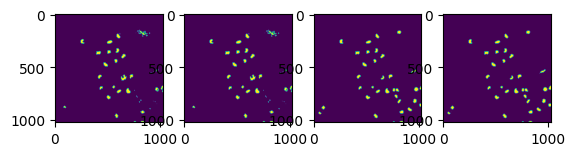

Epoch  40 Training loss:  0.23543388843536378 IoU score:  0.5954234015969233 Time:  1.5794849395751953
Epoch  41 Training loss:  0.22631049156188965 IoU score:  0.6076861647859628 Time:  1.3088467121124268
Epoch  42 Training loss:  0.22395598888397217 IoU score:  0.598967164655948 Time:  1.27181077003479
Epoch  43 Training loss:  0.21901280879974366 IoU score:  0.6518341586650142 Time:  1.3226306438446045
Epoch  44 Training loss:  0.22808005809783935 IoU score:  0.5874875301145471 Time:  1.3239448070526123
Epoch  45 Training loss:  0.2186967372894287 IoU score:  0.5997376845924137 Time:  1.3148653507232666
Epoch  46 Training loss:  0.21344246864318847 IoU score:  0.6589552335792128 Time:  1.3192534446716309
Epoch  47 Training loss:  0.21902055740356446 IoU score:  0.6093926542804606 Time:  1.3148515224456787
Epoch  48 Training loss:  0.22290267944335937 IoU score:  0.6308109707035409 Time:  1.3327600955963135
Epoch  49 Training loss:  0.2272655487060547 IoU score:  0.5526466229448728 T

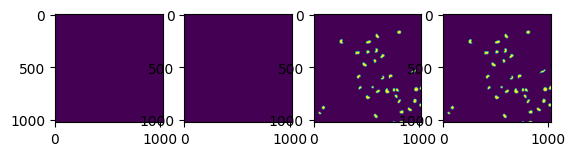

Epoch  0 Training loss:  1.1969654083251953 IoU score:  0.0 Time:  1.6131131649017334
Epoch  1 Training loss:  1.184633159637451 IoU score:  0.0 Time:  1.330373764038086
Epoch  2 Training loss:  1.1697300910949706 IoU score:  0.0 Time:  1.3143036365509033
Epoch  3 Training loss:  1.1439306259155273 IoU score:  0.0 Time:  1.3210506439208984
Epoch  4 Training loss:  1.1189458847045899 IoU score:  0.0 Time:  1.4574353694915771
Epoch  5 Training loss:  1.078559684753418 IoU score:  0.0 Time:  1.2877893447875977
Epoch  6 Training loss:  1.0526389122009276 IoU score:  0.0 Time:  1.2813119888305664
Epoch  7 Training loss:  1.0096834182739258 IoU score:  0.0 Time:  1.2419705390930176
Epoch  8 Training loss:  0.9617286682128906 IoU score:  0.0 Time:  1.2592260837554932
Epoch  9 Training loss:  0.934589958190918 IoU score:  0.0 Time:  1.2682626247406006


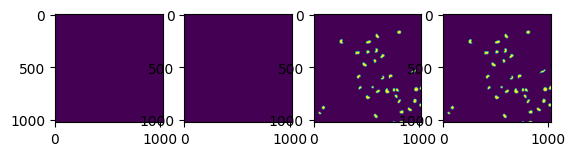

Epoch  10 Training loss:  0.8901412010192871 IoU score:  0.0 Time:  1.5779798030853271
Epoch  11 Training loss:  0.8342860221862793 IoU score:  0.0 Time:  1.2821869850158691
Epoch  12 Training loss:  0.7539454936981201 IoU score:  0.0 Time:  1.2479469776153564
Epoch  13 Training loss:  0.651455020904541 IoU score:  0.0 Time:  1.3016324043273926
Epoch  14 Training loss:  0.5446072578430176 IoU score:  0.0 Time:  1.2926793098449707
Epoch  15 Training loss:  0.47776007652282715 IoU score:  0.0002425023056596061 Time:  1.289160966873169
Epoch  16 Training loss:  0.465871000289917 IoU score:  0.0017933255082191344 Time:  1.3093419075012207
Epoch  17 Training loss:  0.4568449020385742 IoU score:  0.012321851243024345 Time:  1.320819616317749
Epoch  18 Training loss:  0.4215120315551758 IoU score:  0.5543582329266503 Time:  1.304530382156372
Epoch  19 Training loss:  0.30550987720489503 IoU score:  0.5831258219906079 Time:  1.300529956817627


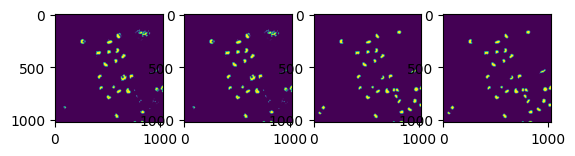

Epoch  20 Training loss:  0.3236131191253662 IoU score:  0.5731925713131731 Time:  1.5856280326843262
Epoch  21 Training loss:  0.3273590564727783 IoU score:  0.5731194743980992 Time:  1.3428640365600586
Epoch  22 Training loss:  0.28935794830322265 IoU score:  0.5877366889071891 Time:  1.329573154449463
Epoch  23 Training loss:  0.32572450637817385 IoU score:  0.5236726048714117 Time:  1.3490281105041504
Epoch  24 Training loss:  0.3093733310699463 IoU score:  0.6151983618308656 Time:  1.356332778930664
Epoch  25 Training loss:  0.30994491577148436 IoU score:  0.6160212150886081 Time:  1.3574304580688477
Epoch  26 Training loss:  0.32182884216308594 IoU score:  0.5133648639682835 Time:  1.3442418575286865
Epoch  27 Training loss:  0.2975767612457275 IoU score:  0.602509543305306 Time:  1.346909761428833
Epoch  28 Training loss:  0.2777922868728638 IoU score:  0.563074874558624 Time:  1.3412845134735107
Epoch  29 Training loss:  0.27074105739593507 IoU score:  0.6237780830252391 Time: 

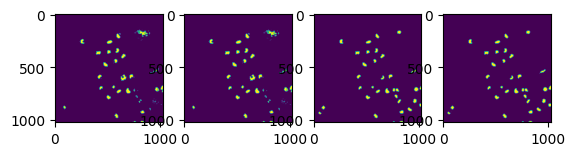

Epoch  30 Training loss:  0.25408382415771485 IoU score:  0.6135296519148803 Time:  1.6182787418365479
Epoch  31 Training loss:  0.25580973625183107 IoU score:  0.5826512816793097 Time:  1.331589937210083
Epoch  32 Training loss:  0.24217963218688965 IoU score:  0.5627815755049083 Time:  1.3526859283447266
Epoch  33 Training loss:  0.24380083084106446 IoU score:  0.6347989917775471 Time:  1.3490502834320068
Epoch  34 Training loss:  0.24858789443969725 IoU score:  0.6163262451719655 Time:  1.3547532558441162
Epoch  35 Training loss:  0.23908133506774903 IoU score:  0.5805465051180683 Time:  1.3434147834777832
Epoch  36 Training loss:  0.24953269958496094 IoU score:  0.5780012761527278 Time:  1.337674856185913
Epoch  37 Training loss:  0.2345428228378296 IoU score:  0.615368682624806 Time:  1.3118414878845215
Epoch  38 Training loss:  0.23456459045410155 IoU score:  0.5693835868919652 Time:  1.3528149127960205
Epoch  39 Training loss:  0.23048782348632812 IoU score:  0.6141186058486101 

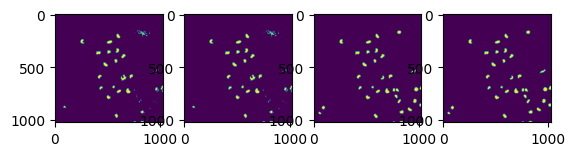

Epoch  40 Training loss:  0.2499708652496338 IoU score:  0.586776326400847 Time:  1.608612298965454
Epoch  41 Training loss:  0.23874156475067138 IoU score:  0.5820384478806504 Time:  1.3377432823181152
Epoch  42 Training loss:  0.22700490951538085 IoU score:  0.6371688220466741 Time:  1.3564448356628418
Epoch  43 Training loss:  0.23109288215637208 IoU score:  0.5421612187104574 Time:  1.2479102611541748
Epoch  44 Training loss:  0.2404477596282959 IoU score:  0.6229842932351211 Time:  1.3182854652404785
Epoch  45 Training loss:  0.22279982566833495 IoU score:  0.6197869026852132 Time:  1.3450100421905518
Epoch  46 Training loss:  0.22679445743560792 IoU score:  0.6066650864606402 Time:  1.3123226165771484
Epoch  47 Training loss:  0.22531869411468505 IoU score:  0.6128954847230763 Time:  1.3532259464263916
Epoch  48 Training loss:  0.2243898868560791 IoU score:  0.6484563131628572 Time:  1.3136334419250488
Epoch  49 Training loss:  0.2253956079483032 IoU score:  0.5946769649144763 Ti

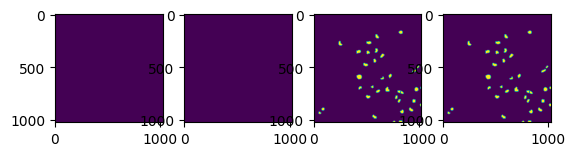

Epoch  0 Training loss:  1.027731990814209 IoU score:  0.0 Time:  1.6133754253387451
Epoch  1 Training loss:  1.018463134765625 IoU score:  0.0 Time:  1.2472262382507324
Epoch  2 Training loss:  0.9993522644042969 IoU score:  0.0 Time:  1.2163357734680176
Epoch  3 Training loss:  0.9734094619750977 IoU score:  0.0 Time:  1.187758207321167
Epoch  4 Training loss:  0.9476169586181641 IoU score:  0.0 Time:  1.199345588684082
Epoch  5 Training loss:  0.9032793045043945 IoU score:  0.0 Time:  1.2387614250183105
Epoch  6 Training loss:  0.8732295036315918 IoU score:  0.0 Time:  1.226346492767334
Epoch  7 Training loss:  0.8351414680480957 IoU score:  0.0 Time:  1.169321060180664
Epoch  8 Training loss:  0.7810227870941162 IoU score:  0.0 Time:  1.2141802310943604
Epoch  9 Training loss:  0.7344497680664063 IoU score:  0.0 Time:  1.2129507064819336


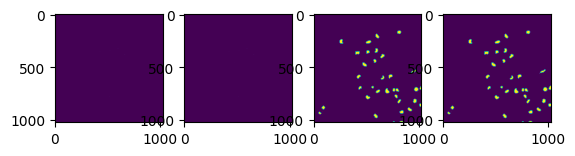

Epoch  10 Training loss:  0.6531912803649902 IoU score:  0.00015098327860189485 Time:  1.5078959465026855
Epoch  11 Training loss:  0.5795011520385742 IoU score:  0.037371045145778034 Time:  1.2476661205291748
Epoch  12 Training loss:  0.4570932865142822 IoU score:  0.41738336652370267 Time:  1.2300734519958496
Epoch  13 Training loss:  0.3611448287963867 IoU score:  0.5064595878504318 Time:  1.2474894523620605
Epoch  14 Training loss:  0.32498807907104493 IoU score:  0.5971121746128807 Time:  1.1953816413879395
Epoch  15 Training loss:  0.28917315006256106 IoU score:  0.578707605126811 Time:  1.1855769157409668
Epoch  16 Training loss:  0.26749606132507325 IoU score:  0.584429664614727 Time:  1.2028987407684326
Epoch  17 Training loss:  0.2691561460494995 IoU score:  0.6140610437013133 Time:  1.2035834789276123
Epoch  18 Training loss:  0.26986706256866455 IoU score:  0.5604094320302173 Time:  1.211501121520996
Epoch  19 Training loss:  0.27203643321990967 IoU score:  0.61667223534481

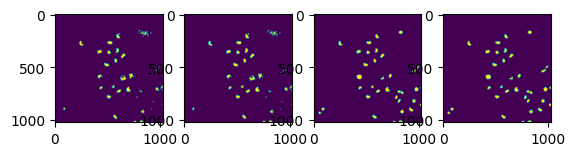

Epoch  20 Training loss:  0.2413543701171875 IoU score:  0.5979974589839375 Time:  1.4985888004302979
Epoch  21 Training loss:  0.23803508281707764 IoU score:  0.6162683486483881 Time:  1.2185256481170654
Epoch  22 Training loss:  0.2376854419708252 IoU score:  0.5899657981175415 Time:  1.2179038524627686
Epoch  23 Training loss:  0.23179256916046143 IoU score:  0.6298601357852776 Time:  1.21925950050354
Epoch  24 Training loss:  0.24040510654449462 IoU score:  0.6118649817704696 Time:  1.1980857849121094
Epoch  25 Training loss:  0.22999191284179688 IoU score:  0.6182285658120822 Time:  1.203460693359375
Epoch  26 Training loss:  0.2253347396850586 IoU score:  0.5969654121425565 Time:  1.2330617904663086
Epoch  27 Training loss:  0.2213205337524414 IoU score:  0.5915599554990822 Time:  1.2093045711517334
Epoch  28 Training loss:  0.22042467594146728 IoU score:  0.5910288445615391 Time:  1.2350401878356934
Epoch  29 Training loss:  0.21753759384155275 IoU score:  0.6303740783570799 Tim

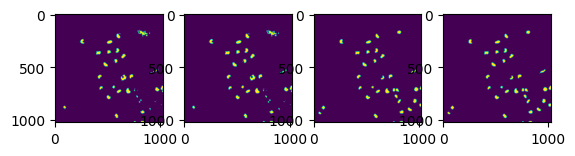

Epoch  30 Training loss:  0.22301688194274902 IoU score:  0.6311752765880086 Time:  1.5623421669006348
Epoch  31 Training loss:  0.21844074726104737 IoU score:  0.5970652771083955 Time:  1.2119982242584229
Epoch  32 Training loss:  0.2171861410140991 IoU score:  0.5974749370244585 Time:  1.2121162414550781
Epoch  33 Training loss:  0.21891193389892577 IoU score:  0.6386666478830579 Time:  1.2277541160583496
Epoch  34 Training loss:  0.21932785511016845 IoU score:  0.6278984070832444 Time:  1.2332494258880615
Epoch  35 Training loss:  0.21446616649627687 IoU score:  0.6282629665031255 Time:  1.2077229022979736
Epoch  36 Training loss:  0.2142101049423218 IoU score:  0.6023259483160159 Time:  1.2285003662109375
Epoch  37 Training loss:  0.2142793655395508 IoU score:  0.605142894765385 Time:  1.231076717376709
Epoch  38 Training loss:  0.21759605407714844 IoU score:  0.6159213165942092 Time:  1.2079393863677979
Epoch  39 Training loss:  0.21162633895874022 IoU score:  0.6678284647583372 T

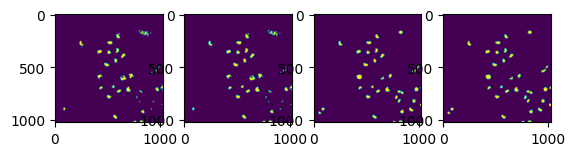

Epoch  40 Training loss:  0.2271270275115967 IoU score:  0.6294311377209172 Time:  1.4628033638000488
Epoch  41 Training loss:  0.22518484592437743 IoU score:  0.6123082451224731 Time:  1.2345056533813477
Epoch  42 Training loss:  0.21682515144348144 IoU score:  0.6663023595831683 Time:  1.2154202461242676
Epoch  43 Training loss:  0.22367687225341798 IoU score:  0.6245286343024948 Time:  1.3130736351013184
Epoch  44 Training loss:  0.23260912895202637 IoU score:  0.6173515740943074 Time:  1.3060612678527832
Epoch  45 Training loss:  0.2180950880050659 IoU score:  0.5906782131146663 Time:  1.2976973056793213
Epoch  46 Training loss:  0.21501147747039795 IoU score:  0.6257465126895982 Time:  1.2916784286499023
Epoch  47 Training loss:  0.21658143997192383 IoU score:  0.6565009553715275 Time:  1.309645652770996
Epoch  48 Training loss:  0.227152419090271 IoU score:  0.6247503290829575 Time:  1.2972760200500488
Epoch  49 Training loss:  0.21154541969299318 IoU score:  0.6515826078934666 T

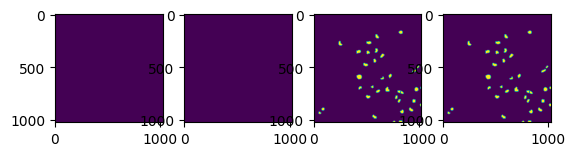

Epoch  0 Training loss:  1.1257471084594726 IoU score:  0.0 Time:  1.5698599815368652
Epoch  1 Training loss:  1.110703182220459 IoU score:  0.0 Time:  1.3397622108459473
Epoch  2 Training loss:  1.0862829208374023 IoU score:  0.0 Time:  1.3547735214233398
Epoch  3 Training loss:  1.054515552520752 IoU score:  0.0 Time:  1.3219313621520996
Epoch  4 Training loss:  1.0195897102355957 IoU score:  0.0 Time:  1.3182392120361328
Epoch  5 Training loss:  0.9840874671936035 IoU score:  0.0 Time:  1.3381891250610352
Epoch  6 Training loss:  0.9463054656982421 IoU score:  0.0 Time:  1.341787338256836
Epoch  7 Training loss:  0.9193230628967285 IoU score:  0.0 Time:  1.334026575088501
Epoch  8 Training loss:  0.8829507827758789 IoU score:  0.0 Time:  1.350928783416748
Epoch  9 Training loss:  0.8211145401000977 IoU score:  0.0 Time:  1.3326025009155273


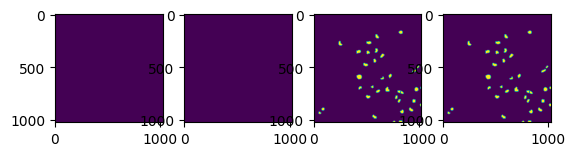

Epoch  10 Training loss:  0.7695704460144043 IoU score:  0.0 Time:  1.6307940483093262
Epoch  11 Training loss:  0.671125078201294 IoU score:  0.0 Time:  1.3613777160644531
Epoch  12 Training loss:  0.5878273010253906 IoU score:  0.0 Time:  1.3393774032592773
Epoch  13 Training loss:  0.5047080993652344 IoU score:  9.331641629700503e-05 Time:  1.3479313850402832
Epoch  14 Training loss:  0.46500563621520996 IoU score:  0.06194012353629779 Time:  1.321192979812622
Epoch  15 Training loss:  0.3722635269165039 IoU score:  0.5201953198704996 Time:  1.2264642715454102
Epoch  16 Training loss:  0.3491149663925171 IoU score:  0.5757563765294245 Time:  1.319183588027954
Epoch  17 Training loss:  0.30686471462249754 IoU score:  0.5117057691397112 Time:  1.3650379180908203
Epoch  18 Training loss:  0.41623554229736326 IoU score:  0.46596316612767874 Time:  1.3357818126678467
Epoch  19 Training loss:  0.2959887981414795 IoU score:  0.5190536010562814 Time:  1.3419287204742432


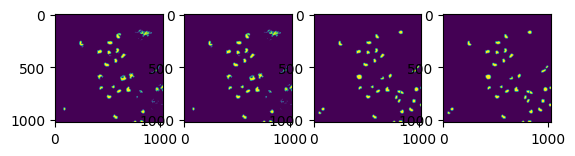

Epoch  20 Training loss:  0.27316596508026125 IoU score:  0.5938895074904118 Time:  1.6012094020843506
Epoch  21 Training loss:  0.25867018699645994 IoU score:  0.5541846439857827 Time:  1.355827808380127
Epoch  22 Training loss:  0.25949361324310305 IoU score:  0.5899154407957715 Time:  1.364881992340088
Epoch  23 Training loss:  0.24830236434936523 IoU score:  0.5911151248134738 Time:  1.3492074012756348
Epoch  24 Training loss:  0.28632071018218996 IoU score:  0.5019302336300743 Time:  1.3521103858947754
Epoch  25 Training loss:  0.29777073860168457 IoU score:  0.6314155687228332 Time:  1.3422002792358398
Epoch  26 Training loss:  0.2617156982421875 IoU score:  0.5645030814423624 Time:  1.358184576034546
Epoch  27 Training loss:  0.24228901863098146 IoU score:  0.6323927273637937 Time:  1.3244178295135498
Epoch  28 Training loss:  0.24574811458587648 IoU score:  0.5290715898992943 Time:  1.3485074043273926
Epoch  29 Training loss:  0.2500422954559326 IoU score:  0.6141920377032577 T

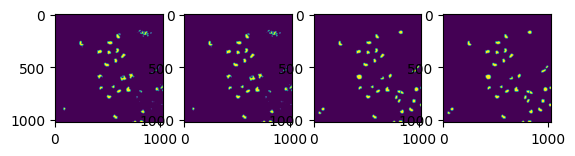

Epoch  30 Training loss:  0.24475324153900146 IoU score:  0.6058981076004564 Time:  1.638617753982544
Epoch  31 Training loss:  0.23216090202331544 IoU score:  0.6497341588820156 Time:  1.367309331893921
Epoch  32 Training loss:  0.2505133628845215 IoU score:  0.5607759320516377 Time:  1.3372607231140137
Epoch  33 Training loss:  0.25764472484588624 IoU score:  0.5992769540423137 Time:  1.3491814136505127
Epoch  34 Training loss:  0.23809442520141602 IoU score:  0.5695561669587021 Time:  1.33024001121521
Epoch  35 Training loss:  0.25028166770935056 IoU score:  0.6039577297590606 Time:  1.3121168613433838
Epoch  36 Training loss:  0.22723150253295898 IoU score:  0.6340795785167768 Time:  1.3583345413208008
Epoch  37 Training loss:  0.2333451271057129 IoU score:  0.5980620280649798 Time:  1.3397634029388428
Epoch  38 Training loss:  0.2311755895614624 IoU score:  0.5423451276520248 Time:  1.3257665634155273
Epoch  39 Training loss:  0.22683362960815429 IoU score:  0.6350875819852086 Tim

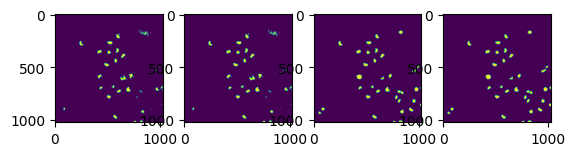

Epoch  40 Training loss:  0.22671725749969482 IoU score:  0.5965313095790522 Time:  1.64607834815979
Epoch  41 Training loss:  0.22018966674804688 IoU score:  0.6298583308686253 Time:  1.3493335247039795
Epoch  42 Training loss:  0.22396249771118165 IoU score:  0.6293737389431978 Time:  1.317596435546875
Epoch  43 Training loss:  0.22014231681823732 IoU score:  0.5769484933886262 Time:  1.3104794025421143
Epoch  44 Training loss:  0.22809791564941406 IoU score:  0.6163135798749824 Time:  1.3278758525848389
Epoch  45 Training loss:  0.23395535945892335 IoU score:  0.6428955468219055 Time:  1.34735107421875
Epoch  46 Training loss:  0.29140970706939695 IoU score:  0.5383261554510324 Time:  1.3570451736450195
Epoch  47 Training loss:  0.2558656454086304 IoU score:  0.6018887530837994 Time:  1.3661634922027588
Epoch  48 Training loss:  0.27771284580230715 IoU score:  0.502829154865573 Time:  1.3793580532073975
Epoch  49 Training loss:  0.23536078929901122 IoU score:  0.6261454124682484 Tim

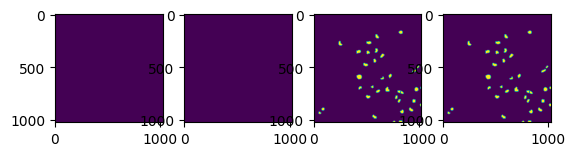

Epoch  0 Training loss:  1.1182214736938476 IoU score:  0.0 Time:  1.591289758682251
Epoch  1 Training loss:  1.1079113960266114 IoU score:  0.0 Time:  1.3329060077667236
Epoch  2 Training loss:  1.0821157455444337 IoU score:  0.0 Time:  1.1881492137908936
Epoch  3 Training loss:  1.0443625450134277 IoU score:  0.0 Time:  1.2033228874206543
Epoch  4 Training loss:  1.0174652099609376 IoU score:  0.0 Time:  1.3424768447875977
Epoch  5 Training loss:  0.9826449394226074 IoU score:  0.0 Time:  1.3696813583374023
Epoch  6 Training loss:  0.9443265914916992 IoU score:  0.0 Time:  1.369600534439087
Epoch  7 Training loss:  0.9022916793823242 IoU score:  0.0 Time:  1.333038568496704
Epoch  8 Training loss:  0.8631402969360351 IoU score:  0.0 Time:  1.3316986560821533
Epoch  9 Training loss:  0.7972360610961914 IoU score:  0.0 Time:  1.3319196701049805


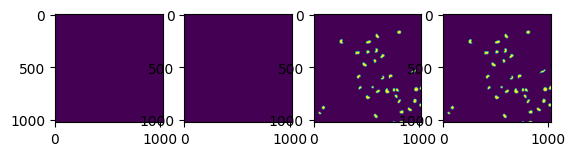

Epoch  10 Training loss:  0.7299642562866211 IoU score:  0.0 Time:  1.6157331466674805
Epoch  11 Training loss:  0.6618617534637451 IoU score:  0.0 Time:  1.3605728149414062
Epoch  12 Training loss:  0.5689087390899659 IoU score:  0.0 Time:  1.341292142868042
Epoch  13 Training loss:  0.4933467388153076 IoU score:  0.016699954364481746 Time:  1.355025053024292
Epoch  14 Training loss:  0.4321112155914307 IoU score:  0.5141238949243621 Time:  1.3552947044372559
Epoch  15 Training loss:  0.3552999496459961 IoU score:  0.49544010518983417 Time:  1.360194444656372
Epoch  16 Training loss:  0.3781332731246948 IoU score:  0.45283040543971786 Time:  1.328904151916504
Epoch  17 Training loss:  0.3139012098312378 IoU score:  0.3750172675502836 Time:  1.3407833576202393
Epoch  18 Training loss:  0.3912771463394165 IoU score:  0.45287251831447184 Time:  1.3536083698272705
Epoch  19 Training loss:  0.3062274932861328 IoU score:  0.5324595570294315 Time:  1.3516120910644531


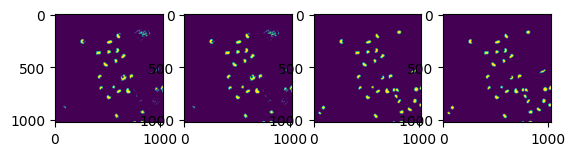

Epoch  20 Training loss:  0.28110127449035643 IoU score:  0.5657908505814823 Time:  1.6270415782928467
Epoch  21 Training loss:  0.2886183738708496 IoU score:  0.6102467770265894 Time:  1.3345680236816406
Epoch  22 Training loss:  0.34763920307159424 IoU score:  0.5999282872823524 Time:  1.323533296585083
Epoch  23 Training loss:  0.30407283306121824 IoU score:  0.6194200024380292 Time:  1.3562042713165283
Epoch  24 Training loss:  0.27745800018310546 IoU score:  0.5651985727074669 Time:  1.3538389205932617
Epoch  25 Training loss:  0.25822546482086184 IoU score:  0.6215111091011125 Time:  1.3548102378845215
Epoch  26 Training loss:  0.250133752822876 IoU score:  0.5923338239860867 Time:  1.2340121269226074
Epoch  27 Training loss:  0.23979291915893555 IoU score:  0.5878076979878774 Time:  1.2523305416107178
Epoch  28 Training loss:  0.24029943943023682 IoU score:  0.6031144068209522 Time:  1.2311656475067139
Epoch  29 Training loss:  0.2447359323501587 IoU score:  0.610280506874384 Ti

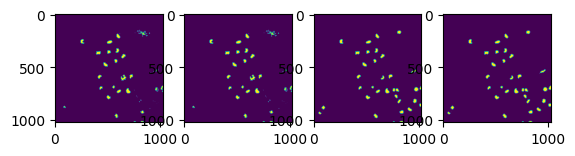

Epoch  30 Training loss:  0.23387699127197265 IoU score:  0.5744944876890402 Time:  1.5259835720062256
Epoch  31 Training loss:  0.24350461959838868 IoU score:  0.6369873878495618 Time:  1.224724292755127
Epoch  32 Training loss:  0.23027238845825196 IoU score:  0.5733657645015138 Time:  1.364670753479004
Epoch  33 Training loss:  0.23221967220306397 IoU score:  0.6024010706730747 Time:  1.29487943649292
Epoch  34 Training loss:  0.2260507345199585 IoU score:  0.5955440963214529 Time:  1.308295726776123
Epoch  35 Training loss:  0.222332763671875 IoU score:  0.6328753160721832 Time:  1.3692748546600342
Epoch  36 Training loss:  0.2288126230239868 IoU score:  0.5432477036594583 Time:  1.3423175811767578
Epoch  37 Training loss:  0.24809346199035645 IoU score:  0.6439879962979497 Time:  1.3291325569152832
Epoch  38 Training loss:  0.23182942867279052 IoU score:  0.5786488830721149 Time:  1.3582842350006104
Epoch  39 Training loss:  0.239432430267334 IoU score:  0.5900239021279621 Time:  

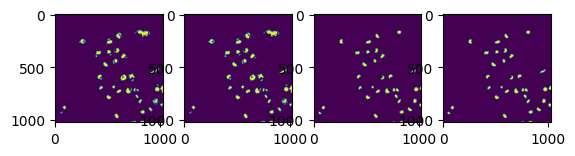

Epoch  40 Training loss:  0.24704692363739014 IoU score:  0.6270116447574168 Time:  1.6092402935028076
Epoch  41 Training loss:  0.27357945442199705 IoU score:  0.6024962853353113 Time:  1.293152093887329
Epoch  42 Training loss:  0.23569302558898925 IoU score:  0.6198979551805572 Time:  1.186349868774414
Epoch  43 Training loss:  0.24115095138549805 IoU score:  0.5733686652609347 Time:  1.2269108295440674
Epoch  44 Training loss:  0.23042259216308594 IoU score:  0.6598262113290354 Time:  1.2666354179382324
Epoch  45 Training loss:  0.2228984832763672 IoU score:  0.6019413847335214 Time:  1.2316770553588867
Epoch  46 Training loss:  0.21835758686065673 IoU score:  0.6297102576271225 Time:  1.2187130451202393
Epoch  47 Training loss:  0.2209240436553955 IoU score:  0.5990705505558763 Time:  1.2390687465667725
Epoch  48 Training loss:  0.22522203922271727 IoU score:  0.5752777728144409 Time:  1.227116584777832
Epoch  49 Training loss:  0.22276368141174316 IoU score:  0.6436190046878794 T

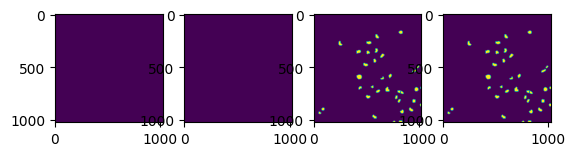

Epoch  0 Training loss:  1.0769586563110352 IoU score:  0.0 Time:  1.4996788501739502
Epoch  1 Training loss:  1.0648893356323241 IoU score:  0.0 Time:  1.255821704864502
Epoch  2 Training loss:  1.0380294799804688 IoU score:  0.0 Time:  1.2294268608093262
Epoch  3 Training loss:  1.0105286598205567 IoU score:  0.0 Time:  1.2381460666656494
Epoch  4 Training loss:  0.9762705802917481 IoU score:  0.0 Time:  1.2021269798278809
Epoch  5 Training loss:  0.9373514175415039 IoU score:  0.0 Time:  1.2070388793945312
Epoch  6 Training loss:  0.8979299545288086 IoU score:  0.0 Time:  1.2457175254821777
Epoch  7 Training loss:  0.8510080337524414 IoU score:  0.0 Time:  1.196953535079956
Epoch  8 Training loss:  0.8025009155273437 IoU score:  0.0 Time:  1.2229042053222656
Epoch  9 Training loss:  0.7362738132476807 IoU score:  0.0 Time:  1.2629892826080322


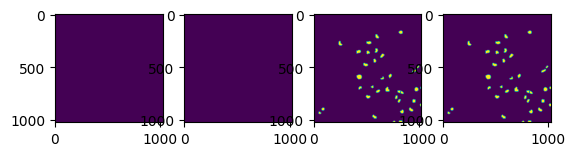

Epoch  10 Training loss:  0.6581069469451905 IoU score:  0.0 Time:  1.5446605682373047
Epoch  11 Training loss:  0.5911577224731446 IoU score:  5.6270513066797674e-05 Time:  1.2028839588165283
Epoch  12 Training loss:  0.4961434841156006 IoU score:  0.008771145171123726 Time:  1.2488477230072021
Epoch  13 Training loss:  0.44265108108520507 IoU score:  0.05538244581212007 Time:  1.2523019313812256
Epoch  14 Training loss:  0.4058922290802002 IoU score:  0.5102478699490842 Time:  1.2167949676513672
Epoch  15 Training loss:  0.29570143222808837 IoU score:  0.5253141943547885 Time:  1.2492146492004395
Epoch  16 Training loss:  0.28546130657196045 IoU score:  0.5667867479197723 Time:  1.1994528770446777
Epoch  17 Training loss:  0.28520951271057127 IoU score:  0.5255062491009679 Time:  1.2210233211517334
Epoch  18 Training loss:  0.29334774017333987 IoU score:  0.5254395550810225 Time:  1.2292580604553223
Epoch  19 Training loss:  0.29215714931488035 IoU score:  0.5591581290397643 Time:  1

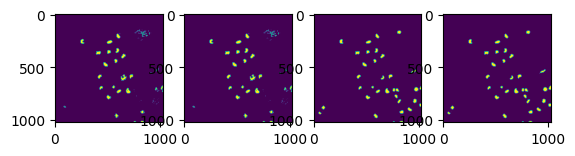

Epoch  20 Training loss:  0.27822659015655515 IoU score:  0.5431810201739665 Time:  1.5185348987579346
Epoch  21 Training loss:  0.2554978370666504 IoU score:  0.6092910352140202 Time:  1.217407464981079
Epoch  22 Training loss:  0.26130859851837157 IoU score:  0.5641486616453959 Time:  1.212735652923584
Epoch  23 Training loss:  0.24596309661865234 IoU score:  0.6083000995370582 Time:  1.2078301906585693
Epoch  24 Training loss:  0.2495635986328125 IoU score:  0.588116324213669 Time:  1.2360503673553467
Epoch  25 Training loss:  0.24114317893981935 IoU score:  0.5543869916091617 Time:  1.2511200904846191
Epoch  26 Training loss:  0.24711029529571532 IoU score:  0.6210907731965623 Time:  1.2630784511566162
Epoch  27 Training loss:  0.23572325706481934 IoU score:  0.6182958032183596 Time:  1.226836919784546
Epoch  28 Training loss:  0.241436767578125 IoU score:  0.5673063593294494 Time:  1.2269346714019775
Epoch  29 Training loss:  0.23992807865142823 IoU score:  0.5896515699516571 Time

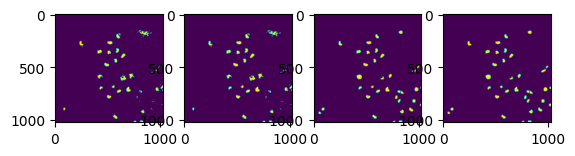

Epoch  30 Training loss:  0.23321754932403566 IoU score:  0.6163451594389793 Time:  1.4915268421173096
Epoch  31 Training loss:  0.22795283794403076 IoU score:  0.6208734673256786 Time:  1.2387025356292725
Epoch  32 Training loss:  0.22897841930389404 IoU score:  0.6157487795101487 Time:  1.280583381652832
Epoch  33 Training loss:  0.23895840644836425 IoU score:  0.6019032537368845 Time:  1.2174944877624512
Epoch  34 Training loss:  0.2328193426132202 IoU score:  0.5982499665816989 Time:  1.1977221965789795
Epoch  35 Training loss:  0.22570343017578126 IoU score:  0.5772113501134135 Time:  1.2335681915283203
Epoch  36 Training loss:  0.2196657419204712 IoU score:  0.6415376916235986 Time:  1.2100579738616943
Epoch  37 Training loss:  0.24051086902618407 IoU score:  0.6179560947540045 Time:  1.2946302890777588
Epoch  38 Training loss:  0.2692436218261719 IoU score:  0.5752919869277044 Time:  1.3400068283081055
Epoch  39 Training loss:  0.24333925247192384 IoU score:  0.5588124154982994 

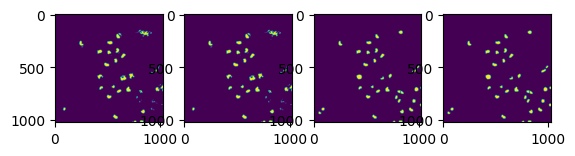

Epoch  40 Training loss:  0.22745852470397948 IoU score:  0.6185823780949022 Time:  1.6142151355743408
Epoch  41 Training loss:  0.229014253616333 IoU score:  0.639267954434055 Time:  1.3470518589019775
Epoch  42 Training loss:  0.24034662246704103 IoU score:  0.5881452514308431 Time:  1.3341972827911377
Epoch  43 Training loss:  0.23674383163452148 IoU score:  0.6183313374929962 Time:  1.3458929061889648
Epoch  44 Training loss:  0.22509338855743408 IoU score:  0.6265646560533851 Time:  1.3565967082977295
Epoch  45 Training loss:  0.21878595352172853 IoU score:  0.6354221426971469 Time:  1.34869384765625
Epoch  46 Training loss:  0.2519193649291992 IoU score:  0.6425103684518203 Time:  1.355851650238037
Epoch  47 Training loss:  0.23643243312835693 IoU score:  0.595813291425285 Time:  1.3678781986236572
Epoch  48 Training loss:  0.21897313594818116 IoU score:  0.640445180985188 Time:  1.237769365310669
Epoch  49 Training loss:  0.21948468685150146 IoU score:  0.5329328714554448 Time: 

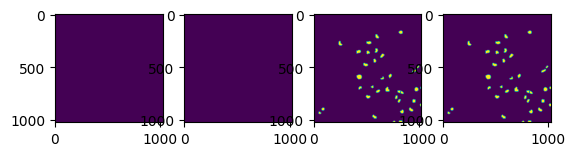

Epoch  0 Training loss:  1.2642050743103028 IoU score:  0.0 Time:  1.6330888271331787
Epoch  1 Training loss:  1.2623117446899415 IoU score:  0.0 Time:  1.3449621200561523
Epoch  2 Training loss:  1.2578990936279297 IoU score:  0.0 Time:  1.3465957641601562
Epoch  3 Training loss:  1.249305534362793 IoU score:  0.0 Time:  1.341284990310669
Epoch  4 Training loss:  1.239241886138916 IoU score:  0.0 Time:  1.3435280323028564
Epoch  5 Training loss:  1.2159011840820313 IoU score:  0.0 Time:  1.3538966178894043
Epoch  6 Training loss:  1.1821932792663574 IoU score:  0.0 Time:  1.3394253253936768
Epoch  7 Training loss:  1.1449003219604492 IoU score:  0.0 Time:  1.3452720642089844
Epoch  8 Training loss:  1.0932271003723144 IoU score:  0.0 Time:  1.3600380420684814
Epoch  9 Training loss:  1.0419209480285645 IoU score:  0.0 Time:  1.3687610626220703


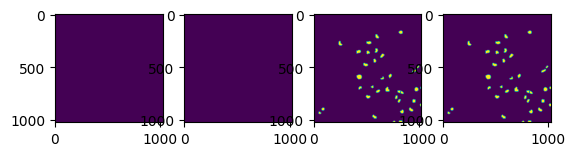

Epoch  10 Training loss:  1.004997444152832 IoU score:  0.0 Time:  1.6166720390319824
Epoch  11 Training loss:  0.9648147583007812 IoU score:  0.0 Time:  1.3360607624053955
Epoch  12 Training loss:  0.8967297554016114 IoU score:  0.0 Time:  1.3125519752502441
Epoch  13 Training loss:  0.837993049621582 IoU score:  0.0 Time:  1.2969307899475098
Epoch  14 Training loss:  0.7169177055358886 IoU score:  0.0 Time:  1.3156917095184326
Epoch  15 Training loss:  0.5769585609436035 IoU score:  0.0 Time:  1.306464433670044
Epoch  16 Training loss:  0.4713726043701172 IoU score:  0.001999104534058747 Time:  1.3369848728179932
Epoch  17 Training loss:  0.449114990234375 IoU score:  0.005983320081219224 Time:  1.3329355716705322
Epoch  18 Training loss:  0.43273077011108396 IoU score:  0.014434366671108194 Time:  1.3085639476776123
Epoch  19 Training loss:  0.42429409027099607 IoU score:  0.03515730447372942 Time:  1.2960689067840576


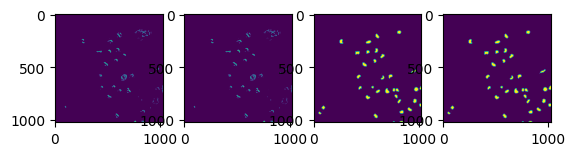

Epoch  20 Training loss:  0.412119197845459 IoU score:  0.10492899449357522 Time:  1.5248987674713135
Epoch  21 Training loss:  0.39017372131347655 IoU score:  0.5588912038506916 Time:  1.211033582687378
Epoch  22 Training loss:  0.3773586511611938 IoU score:  0.5497962114830024 Time:  1.374636173248291
Epoch  23 Training loss:  0.3190906286239624 IoU score:  0.5213860046687374 Time:  1.3474199771881104
Epoch  24 Training loss:  0.2995772838592529 IoU score:  0.5485585103879198 Time:  1.3162174224853516
Epoch  25 Training loss:  0.3149925708770752 IoU score:  0.5372272859397687 Time:  1.3545947074890137
Epoch  26 Training loss:  0.28977668285369873 IoU score:  0.5611961693209003 Time:  1.3537180423736572
Epoch  27 Training loss:  0.27656238079071044 IoU score:  0.592085251651466 Time:  1.3123633861541748
Epoch  28 Training loss:  0.2792074680328369 IoU score:  0.5950098276227391 Time:  1.3453068733215332
Epoch  29 Training loss:  0.2449416160583496 IoU score:  0.5960191604811524 Time: 

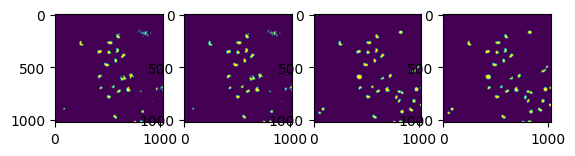

Epoch  30 Training loss:  0.24045994281768798 IoU score:  0.5617235669028504 Time:  1.6070671081542969
Epoch  31 Training loss:  0.2473320722579956 IoU score:  0.5988157214263478 Time:  1.3361144065856934
Epoch  32 Training loss:  0.24402053356170655 IoU score:  0.6267588260377628 Time:  1.3557417392730713
Epoch  33 Training loss:  0.23552727699279785 IoU score:  0.5687545025396471 Time:  1.3514127731323242
Epoch  34 Training loss:  0.22498221397399903 IoU score:  0.6271583231539605 Time:  1.3668384552001953
Epoch  35 Training loss:  0.23328404426574706 IoU score:  0.5536139245445907 Time:  1.3635287284851074
Epoch  36 Training loss:  0.2249272108078003 IoU score:  0.6376868866952909 Time:  1.3579692840576172
Epoch  37 Training loss:  0.2403346538543701 IoU score:  0.6039483479399012 Time:  1.3569457530975342
Epoch  38 Training loss:  0.2482595205307007 IoU score:  0.6242525541484925 Time:  1.3610544204711914
Epoch  39 Training loss:  0.25402355194091797 IoU score:  0.6014929418625606 

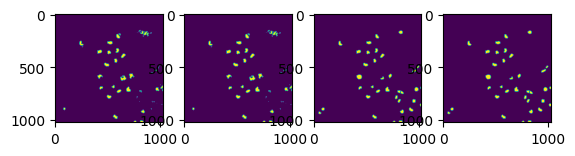

Epoch  40 Training loss:  0.24699997901916504 IoU score:  0.6114623758879658 Time:  1.6145458221435547
Epoch  41 Training loss:  0.24842817783355714 IoU score:  0.6344171166665802 Time:  1.3653669357299805
Epoch  42 Training loss:  0.2363257884979248 IoU score:  0.537677132811476 Time:  1.3410451412200928
Epoch  43 Training loss:  0.27119057178497313 IoU score:  0.5854981423266692 Time:  1.3601627349853516
Epoch  44 Training loss:  0.24606633186340332 IoU score:  0.6205222565714577 Time:  1.3644435405731201
Epoch  45 Training loss:  0.3001063108444214 IoU score:  0.5425423970965311 Time:  1.3577203750610352
Epoch  46 Training loss:  0.24587690830230713 IoU score:  0.5995031221892166 Time:  1.3610742092132568
Epoch  47 Training loss:  0.22263808250427247 IoU score:  0.6409277265927742 Time:  1.3357923030853271
Epoch  48 Training loss:  0.22206621170043944 IoU score:  0.5892474704309685 Time:  1.3170149326324463
Epoch  49 Training loss:  0.2290111780166626 IoU score:  0.6613364875713521 

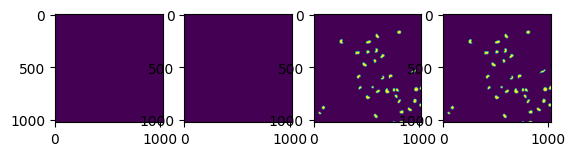

Epoch  0 Training loss:  1.0886890411376953 IoU score:  0.0 Time:  1.5104517936706543
Epoch  1 Training loss:  1.076429843902588 IoU score:  0.0 Time:  1.2594401836395264
Epoch  2 Training loss:  1.0450982093811034 IoU score:  0.0 Time:  1.2506389617919922
Epoch  3 Training loss:  1.0231829643249513 IoU score:  0.0 Time:  1.2465152740478516
Epoch  4 Training loss:  0.9928479194641113 IoU score:  0.0 Time:  1.1970152854919434
Epoch  5 Training loss:  0.9574042320251465 IoU score:  0.0 Time:  1.2160735130310059
Epoch  6 Training loss:  0.9097115516662597 IoU score:  0.0 Time:  1.2494807243347168
Epoch  7 Training loss:  0.8636538505554199 IoU score:  0.0 Time:  1.227123498916626
Epoch  8 Training loss:  0.8067439079284668 IoU score:  0.0 Time:  1.226978063583374
Epoch  9 Training loss:  0.7310028076171875 IoU score:  0.0 Time:  1.1966722011566162


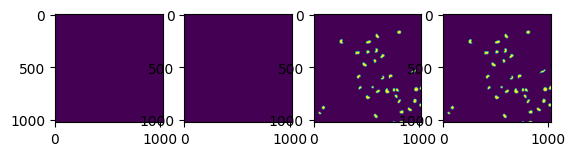

Epoch  10 Training loss:  0.6328710079193115 IoU score:  0.0 Time:  1.5141499042510986
Epoch  11 Training loss:  0.5688735008239746 IoU score:  0.0 Time:  1.2543189525604248
Epoch  12 Training loss:  0.5049398422241211 IoU score:  0.016965145932311347 Time:  1.2366986274719238
Epoch  13 Training loss:  0.43102388381958007 IoU score:  0.4730815426415609 Time:  1.211587905883789
Epoch  14 Training loss:  0.3561390399932861 IoU score:  0.549930422178183 Time:  1.2133147716522217
Epoch  15 Training loss:  0.3244726896286011 IoU score:  0.5273390322617447 Time:  1.225391149520874
Epoch  16 Training loss:  0.35558152198791504 IoU score:  0.521783056234064 Time:  1.1980900764465332
Epoch  17 Training loss:  0.361781644821167 IoU score:  0.39478769654233925 Time:  1.2652416229248047
Epoch  18 Training loss:  0.31023216247558594 IoU score:  0.5781586265507181 Time:  1.355494499206543
Epoch  19 Training loss:  0.2906126260757446 IoU score:  0.5441381456674598 Time:  1.3381679058074951


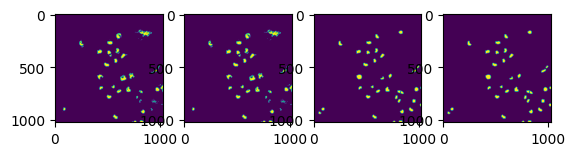

Epoch  20 Training loss:  0.2844399452209473 IoU score:  0.6046771907567892 Time:  1.6325151920318604
Epoch  21 Training loss:  0.2728226900100708 IoU score:  0.5717752757109817 Time:  1.384551763534546
Epoch  22 Training loss:  0.25838489532470704 IoU score:  0.5552009006356431 Time:  1.3555068969726562
Epoch  23 Training loss:  0.2543126821517944 IoU score:  0.6074674787711158 Time:  1.3258512020111084
Epoch  24 Training loss:  0.2532464265823364 IoU score:  0.5610278063667384 Time:  1.3532211780548096
Epoch  25 Training loss:  0.24565789699554444 IoU score:  0.591930284182028 Time:  1.3531134128570557
Epoch  26 Training loss:  0.2415313720703125 IoU score:  0.5192008980972165 Time:  1.373295545578003
Epoch  27 Training loss:  0.2708526849746704 IoU score:  0.6045660510692155 Time:  1.3638341426849365
Epoch  28 Training loss:  0.25626473426818847 IoU score:  0.5797075733585619 Time:  1.3414890766143799
Epoch  29 Training loss:  0.2607953310012817 IoU score:  0.5469042101852111 Time: 

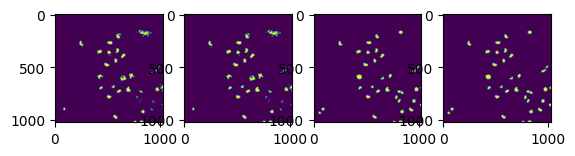

Epoch  30 Training loss:  0.243641996383667 IoU score:  0.628846833214087 Time:  1.6081862449645996
Epoch  31 Training loss:  0.24722669124603272 IoU score:  0.6168480908388557 Time:  1.3069653511047363
Epoch  32 Training loss:  0.24351792335510253 IoU score:  0.5672276416057845 Time:  1.2407093048095703
Epoch  33 Training loss:  0.22943906784057616 IoU score:  0.6287311349346142 Time:  1.216118335723877
Epoch  34 Training loss:  0.24088518619537352 IoU score:  0.6216177093386023 Time:  1.2393262386322021
Epoch  35 Training loss:  0.2338348388671875 IoU score:  0.5360032522872832 Time:  1.2707431316375732
Epoch  36 Training loss:  0.24065403938293456 IoU score:  0.6482243126965197 Time:  1.2941341400146484
Epoch  37 Training loss:  0.2337418556213379 IoU score:  0.5686958517949806 Time:  1.2015526294708252
Epoch  38 Training loss:  0.23075006008148194 IoU score:  0.5643162660840146 Time:  1.197504997253418
Epoch  39 Training loss:  0.23828883171081544 IoU score:  0.6342120103584152 Tim

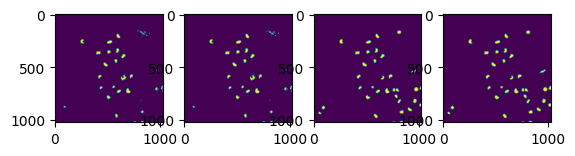

Epoch  40 Training loss:  0.23942477703094484 IoU score:  0.5490538953425145 Time:  1.5489356517791748
Epoch  41 Training loss:  0.22858638763427735 IoU score:  0.6265282388262303 Time:  1.2336535453796387
Epoch  42 Training loss:  0.23514630794525146 IoU score:  0.5622779488551863 Time:  1.2411763668060303
Epoch  43 Training loss:  0.2282411813735962 IoU score:  0.5948933235520877 Time:  1.2544770240783691
Epoch  44 Training loss:  0.22324812412261963 IoU score:  0.6275744163986293 Time:  1.2774858474731445
Epoch  45 Training loss:  0.22084505558013917 IoU score:  0.6146327031308558 Time:  1.2380354404449463
Epoch  46 Training loss:  0.22889177799224852 IoU score:  0.5208661076559005 Time:  1.3429532051086426
Epoch  47 Training loss:  0.2424238920211792 IoU score:  0.6446558306735312 Time:  1.27158784866333
Epoch  48 Training loss:  0.2305349588394165 IoU score:  0.6369470886939868 Time:  1.2288196086883545
Epoch  49 Training loss:  0.2448943853378296 IoU score:  0.624121353435771 Tim

In [ ]:
seeds = [0,1,2,3,4,5,6,7,8,9,10]

for seed in seeds:
    print('Seed:',seed)
    unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
    
    unet.load_state_dict(torch.load("/Users/av337/Documents/developmentRehan/distillCellSegTrack/pipeline/base_model"))
    
    unet.encoder.requires_grad_ = False
    unet.decoder.requires_grad_ = False

    torch.manual_seed(seed)
    unet.head.weight = torch.nn.Parameter(torch.rand(unet.head.weight.shape))

    unet = unet.to('cuda:0')
    
    loss_fn = LF_two()
    optimiser = torch.optim.SGD(unet.parameters(), lr=0.01, momentum=0.1)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=0.01)
    for epoch in range(50):
        unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=2, device='cuda:0')
    print('\n')

In [ ]:
print(train_loader[0])

TypeError: 'DataLoader' object is not subscriptable

C:\Users\av337\AppData\Local\Temp\ipykernel_25396\2565813840.py:86: RuntimeWarning: overflow encountered in exp
  y_3_pred = 1/(1+np.exp(-y_3_pred))


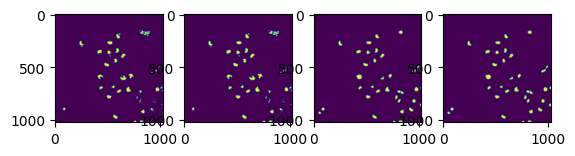

Epoch  0 Training loss:  0.20847272872924805 IoU score:  0.0 Time:  1.7461979389190674
Epoch  1 Training loss:  0.2083484411239624 IoU score:  0.0 Time:  1.2767605781555176
Epoch  2 Training loss:  0.20821044445037842 IoU score:  0.0 Time:  1.3145411014556885
Epoch  3 Training loss:  0.2079930305480957 IoU score:  0.0 Time:  1.2831523418426514
Epoch  4 Training loss:  0.20782454013824464 IoU score:  0.0 Time:  1.3269755840301514
Epoch  5 Training loss:  0.20755228996276856 IoU score:  0.0 Time:  1.3078923225402832
Epoch  6 Training loss:  0.20736804008483886 IoU score:  0.0 Time:  1.2654366493225098
Epoch  7 Training loss:  0.20715818405151368 IoU score:  0.0 Time:  1.303689956665039
Epoch  8 Training loss:  0.20691709518432616 IoU score:  0.0 Time:  1.3301730155944824
Epoch  9 Training loss:  0.2067565441131592 IoU score:  0.0 Time:  1.3191032409667969


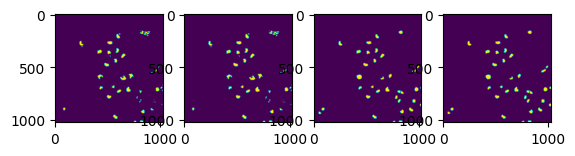

Epoch  10 Training loss:  0.20650413036346435 IoU score:  0.0 Time:  1.5865888595581055
Epoch  11 Training loss:  0.2063453197479248 IoU score:  0.0 Time:  1.3437111377716064
Epoch  12 Training loss:  0.2061075210571289 IoU score:  0.0 Time:  1.3195016384124756
Epoch  13 Training loss:  0.20592668056488037 IoU score:  0.0 Time:  1.2949070930480957
Epoch  14 Training loss:  0.2057868003845215 IoU score:  0.0 Time:  1.323512077331543
Epoch  15 Training loss:  0.2055889129638672 IoU score:  0.0 Time:  1.2778599262237549
Epoch  16 Training loss:  0.20540742874145507 IoU score:  0.0 Time:  1.3087730407714844
Epoch  17 Training loss:  0.20525693893432617 IoU score:  0.0 Time:  1.3604984283447266
Epoch  18 Training loss:  0.2051037073135376 IoU score:  0.0 Time:  1.3332452774047852
Epoch  19 Training loss:  0.20489468574523925 IoU score:  0.0 Time:  1.4918806552886963


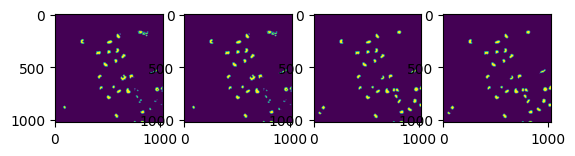

Epoch  20 Training loss:  0.2047278881072998 IoU score:  0.0 Time:  1.5661983489990234
Epoch  21 Training loss:  0.204583477973938 IoU score:  0.0 Time:  1.3584961891174316
Epoch  22 Training loss:  0.20441126823425293 IoU score:  0.0 Time:  1.3534667491912842
Epoch  23 Training loss:  0.2042726993560791 IoU score:  0.0 Time:  1.3360817432403564
Epoch  24 Training loss:  0.20411674976348876 IoU score:  0.0 Time:  1.3534066677093506
Epoch  25 Training loss:  0.20394821166992189 IoU score:  0.0 Time:  1.3377022743225098
Epoch  26 Training loss:  0.2038274049758911 IoU score:  0.0 Time:  1.3600845336914062
Epoch  27 Training loss:  0.20366301536560058 IoU score:  0.0 Time:  1.3635609149932861
Epoch  28 Training loss:  0.2034701108932495 IoU score:  0.0 Time:  1.3224246501922607
Epoch  29 Training loss:  0.20331282615661622 IoU score:  0.0 Time:  1.292893886566162


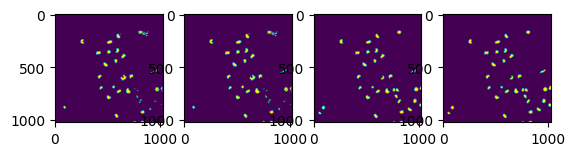

Epoch  30 Training loss:  0.2031705379486084 IoU score:  0.0 Time:  1.6118488311767578
Epoch  31 Training loss:  0.2029975414276123 IoU score:  0.0 Time:  1.338494062423706
Epoch  32 Training loss:  0.20280563831329346 IoU score:  0.0 Time:  1.3050861358642578
Epoch  33 Training loss:  0.20273821353912352 IoU score:  0.0 Time:  1.2976086139678955
Epoch  34 Training loss:  0.20248897075653077 IoU score:  0.0 Time:  1.3138160705566406
Epoch  35 Training loss:  0.202382493019104 IoU score:  0.0 Time:  1.365760087966919
Epoch  36 Training loss:  0.20225517749786376 IoU score:  0.0 Time:  1.3153879642486572
Epoch  37 Training loss:  0.20209343433380128 IoU score:  0.0 Time:  1.2778465747833252
Epoch  38 Training loss:  0.20191187858581544 IoU score:  0.0 Time:  1.3349769115447998
Epoch  39 Training loss:  0.20169386863708497 IoU score:  0.0 Time:  1.2856619358062744


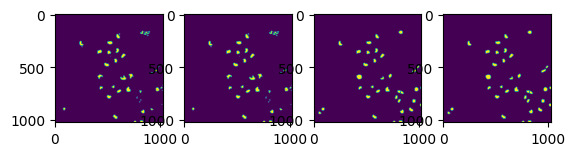

Epoch  40 Training loss:  0.2015904664993286 IoU score:  0.0 Time:  1.5914199352264404
Epoch  41 Training loss:  0.20139749050140382 IoU score:  0.0 Time:  1.342820644378662
Epoch  42 Training loss:  0.2012418031692505 IoU score:  0.0 Time:  1.3184592723846436
Epoch  43 Training loss:  0.20105938911437987 IoU score:  0.0 Time:  1.335005521774292
Epoch  44 Training loss:  0.20096988677978517 IoU score:  0.0 Time:  1.3129558563232422
Epoch  45 Training loss:  0.20077860355377197 IoU score:  0.0 Time:  1.3185436725616455
Epoch  46 Training loss:  0.20066227912902831 IoU score:  0.0 Time:  1.3234786987304688
Epoch  47 Training loss:  0.20059466361999512 IoU score:  0.0 Time:  1.3770551681518555
Epoch  48 Training loss:  0.20038990974426268 IoU score:  0.0 Time:  1.347487449645996
Epoch  49 Training loss:  0.20023682117462158 IoU score:  0.0 Time:  1.2967169284820557


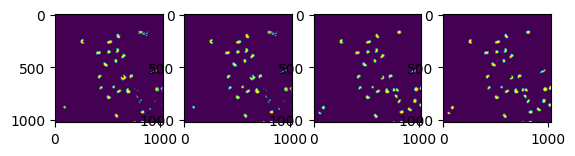

Epoch  50 Training loss:  0.2000883102416992 IoU score:  0.0 Time:  1.6211211681365967
Epoch  51 Training loss:  0.1999834179878235 IoU score:  0.0 Time:  1.3481550216674805
Epoch  52 Training loss:  0.19985769987106322 IoU score:  0.0 Time:  1.3615777492523193
Epoch  53 Training loss:  0.19972460269927977 IoU score:  0.0 Time:  1.2803192138671875
Epoch  54 Training loss:  0.19957826137542725 IoU score:  0.0 Time:  1.2996735572814941
Epoch  55 Training loss:  0.1994176149368286 IoU score:  0.0 Time:  1.3350553512573242
Epoch  56 Training loss:  0.19931535720825194 IoU score:  0.0 Time:  1.3137140274047852
Epoch  57 Training loss:  0.19916666746139527 IoU score:  0.0 Time:  1.352829933166504
Epoch  58 Training loss:  0.19899982213974 IoU score:  0.0 Time:  1.3817028999328613
Epoch  59 Training loss:  0.19884397983551025 IoU score:  0.0 Time:  1.2654573917388916


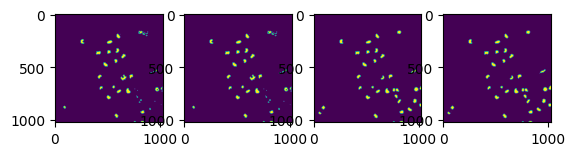

Epoch  60 Training loss:  0.19877568483352662 IoU score:  0.0 Time:  1.610471248626709
Epoch  61 Training loss:  0.19863612651824952 IoU score:  0.0 Time:  1.3379323482513428
Epoch  62 Training loss:  0.19854958057403566 IoU score:  0.0 Time:  1.3570075035095215
Epoch  63 Training loss:  0.1984747529029846 IoU score:  0.0 Time:  1.3380579948425293
Epoch  64 Training loss:  0.19836171865463256 IoU score:  0.0 Time:  1.2711522579193115
Epoch  65 Training loss:  0.19825054407119752 IoU score:  0.0 Time:  1.2748711109161377
Epoch  66 Training loss:  0.19818670749664308 IoU score:  0.0 Time:  1.3910293579101562
Epoch  67 Training loss:  0.1980873465538025 IoU score:  0.0 Time:  1.3294532299041748
Epoch  68 Training loss:  0.19801628589630127 IoU score:  0.0 Time:  1.3171319961547852
Epoch  69 Training loss:  0.19794195890426636 IoU score:  0.0 Time:  1.3471198081970215


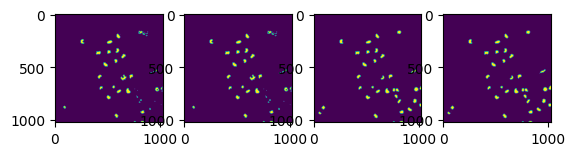

Epoch  70 Training loss:  0.1978812575340271 IoU score:  0.0 Time:  1.5552353858947754
Epoch  71 Training loss:  0.19782018661499023 IoU score:  0.0 Time:  1.495589017868042
Epoch  72 Training loss:  0.19776408672332763 IoU score:  0.0 Time:  1.307262897491455
Epoch  73 Training loss:  0.19772062301635743 IoU score:  0.0 Time:  1.2789278030395508
Epoch  74 Training loss:  0.19767223596572875 IoU score:  0.0 Time:  1.296105146408081
Epoch  75 Training loss:  0.19760210514068605 IoU score:  0.0 Time:  1.2958145141601562
Epoch  76 Training loss:  0.19754610061645508 IoU score:  0.0 Time:  1.278865098953247
Epoch  77 Training loss:  0.1975051760673523 IoU score:  0.0 Time:  1.3599724769592285
Epoch  78 Training loss:  0.19747257232666016 IoU score:  0.0 Time:  1.3625280857086182
Epoch  79 Training loss:  0.19742581844329835 IoU score:  0.0 Time:  1.342238187789917


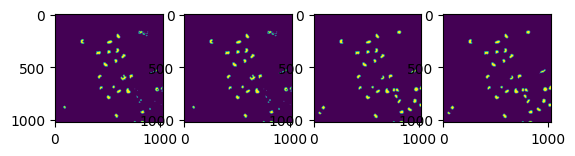

Epoch  80 Training loss:  0.19738658666610717 IoU score:  0.0 Time:  1.627098560333252
Epoch  81 Training loss:  0.19736242294311523 IoU score:  0.0 Time:  1.3258116245269775
Epoch  82 Training loss:  0.1973111152648926 IoU score:  0.0 Time:  1.3845689296722412
Epoch  83 Training loss:  0.19727725982666017 IoU score:  0.0 Time:  1.3292145729064941
Epoch  84 Training loss:  0.19725494384765624 IoU score:  0.0 Time:  1.3771116733551025
Epoch  85 Training loss:  0.197216260433197 IoU score:  0.0 Time:  1.4168944358825684
Epoch  86 Training loss:  0.1971948742866516 IoU score:  0.0 Time:  1.3983466625213623
Epoch  87 Training loss:  0.19716619253158568 IoU score:  0.0 Time:  1.3491005897521973
Epoch  88 Training loss:  0.19714299440383912 IoU score:  0.0 Time:  1.3889074325561523
Epoch  89 Training loss:  0.1971321702003479 IoU score:  0.0 Time:  1.401890516281128


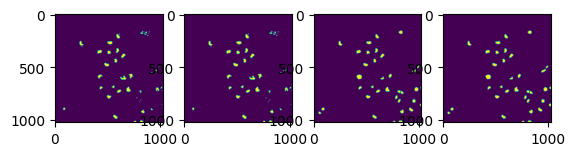

Epoch  90 Training loss:  0.19710367918014526 IoU score:  0.0 Time:  1.6419868469238281
Epoch  91 Training loss:  0.19707871675491334 IoU score:  0.0 Time:  1.3929243087768555
Epoch  92 Training loss:  0.19705550670623778 IoU score:  0.0 Time:  1.360058307647705
Epoch  93 Training loss:  0.19703856706619263 IoU score:  0.0 Time:  1.3441314697265625
Epoch  94 Training loss:  0.19698774814605713 IoU score:  0.0 Time:  1.3131163120269775
Epoch  95 Training loss:  0.19695895910263062 IoU score:  0.0 Time:  1.369147539138794
Epoch  96 Training loss:  0.1969458818435669 IoU score:  0.0 Time:  1.3182928562164307
Epoch  97 Training loss:  0.19692362546920777 IoU score:  0.0 Time:  1.3273122310638428
Epoch  98 Training loss:  0.19691159725189208 IoU score:  0.0 Time:  1.3351025581359863
Epoch  99 Training loss:  0.19688720703125 IoU score:  0.0 Time:  1.338266372680664


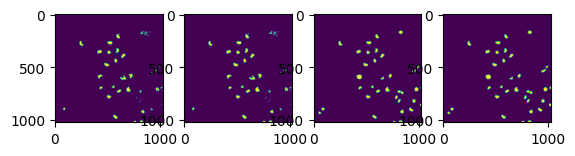

Epoch  100 Training loss:  0.1968700408935547 IoU score:  0.0 Time:  1.5853240489959717
Epoch  101 Training loss:  0.1968618154525757 IoU score:  0.0 Time:  1.371948003768921
Epoch  102 Training loss:  0.19683516025543213 IoU score:  0.0 Time:  1.311903476715088
Epoch  103 Training loss:  0.19681837558746337 IoU score:  0.0 Time:  1.383725643157959
Epoch  104 Training loss:  0.19680160284042358 IoU score:  0.0 Time:  1.3350074291229248
Epoch  105 Training loss:  0.19678792953491211 IoU score:  0.0 Time:  1.2802767753601074
Epoch  106 Training loss:  0.19676626920700074 IoU score:  0.0 Time:  1.3443348407745361
Epoch  107 Training loss:  0.19675130844116212 IoU score:  0.0 Time:  1.3622312545776367
Epoch  108 Training loss:  0.19674525260925294 IoU score:  0.0 Time:  1.2747204303741455
Epoch  109 Training loss:  0.19672613143920897 IoU score:  0.0 Time:  1.3532779216766357


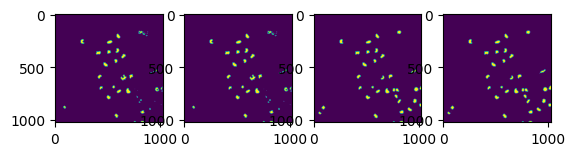

Epoch  110 Training loss:  0.1967170476913452 IoU score:  0.0 Time:  1.606220006942749
Epoch  111 Training loss:  0.19670348167419432 IoU score:  0.0 Time:  1.3439304828643799
Epoch  112 Training loss:  0.19669269323348998 IoU score:  0.0 Time:  1.3317177295684814
Epoch  113 Training loss:  0.19668011665344237 IoU score:  0.0 Time:  1.3245272636413574
Epoch  114 Training loss:  0.19668728113174438 IoU score:  0.0 Time:  1.2962863445281982
Epoch  115 Training loss:  0.19667325019836426 IoU score:  0.0 Time:  1.371830940246582
Epoch  116 Training loss:  0.19667972326278688 IoU score:  0.0 Time:  1.3776311874389648
Epoch  117 Training loss:  0.19665279388427734 IoU score:  0.0 Time:  1.3390848636627197
Epoch  118 Training loss:  0.19663859605789186 IoU score:  0.0 Time:  1.3209176063537598
Epoch  119 Training loss:  0.19663751125335693 IoU score:  0.0 Time:  1.336646556854248


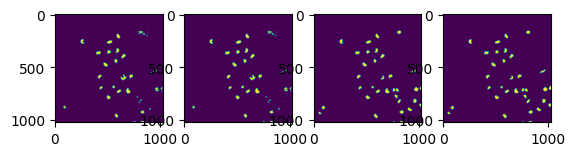

Epoch  120 Training loss:  0.1966403007507324 IoU score:  0.0 Time:  1.6751172542572021
Epoch  121 Training loss:  0.19663667678833008 IoU score:  0.0 Time:  1.3337678909301758
Epoch  122 Training loss:  0.19660993814468383 IoU score:  0.0 Time:  1.3791286945343018
Epoch  123 Training loss:  0.19661920070648192 IoU score:  0.0 Time:  1.3015687465667725
Epoch  124 Training loss:  0.19660600423812866 IoU score:  0.0 Time:  1.3344688415527344
Epoch  125 Training loss:  0.19659805297851562 IoU score:  0.0 Time:  1.3949506282806396
Epoch  126 Training loss:  0.19658708572387695 IoU score:  0.0 Time:  1.3748395442962646
Epoch  127 Training loss:  0.19657982587814332 IoU score:  0.0 Time:  1.5246784687042236
Epoch  128 Training loss:  0.19656970500946044 IoU score:  0.0 Time:  1.6555252075195312
Epoch  129 Training loss:  0.19655704498291016 IoU score:  0.0 Time:  1.5034775733947754


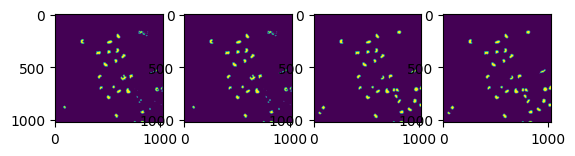

Epoch  130 Training loss:  0.19655001163482666 IoU score:  0.0 Time:  1.6330039501190186
Epoch  131 Training loss:  0.19654109477996826 IoU score:  0.0 Time:  1.3345255851745605
Epoch  132 Training loss:  0.19653111696243286 IoU score:  0.0 Time:  1.2768135070800781
Epoch  133 Training loss:  0.19652010202407838 IoU score:  0.0 Time:  1.3429462909698486
Epoch  134 Training loss:  0.19651010036468505 IoU score:  0.0 Time:  1.3563077449798584
Epoch  135 Training loss:  0.19650298357009888 IoU score:  0.0 Time:  1.3535194396972656
Epoch  136 Training loss:  0.19649744033813477 IoU score:  0.0 Time:  1.3548603057861328
Epoch  137 Training loss:  0.1964842915534973 IoU score:  0.0 Time:  1.332913875579834
Epoch  138 Training loss:  0.19647104740142823 IoU score:  0.0 Time:  1.3335669040679932
Epoch  139 Training loss:  0.1964629054069519 IoU score:  0.0 Time:  1.3555293083190918


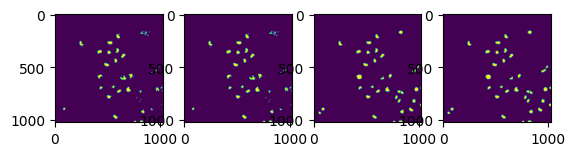

Epoch  140 Training loss:  0.19645814895629882 IoU score:  0.0 Time:  1.6656908988952637
Epoch  141 Training loss:  0.19644737243652344 IoU score:  0.0 Time:  1.3170051574707031
Epoch  142 Training loss:  0.19643831253051758 IoU score:  0.0 Time:  1.3536899089813232
Epoch  143 Training loss:  0.19642994403839112 IoU score:  0.0 Time:  1.3259623050689697
Epoch  144 Training loss:  0.19641247987747193 IoU score:  0.0 Time:  1.321730375289917
Epoch  145 Training loss:  0.19640666246414185 IoU score:  0.0 Time:  1.3563411235809326
Epoch  146 Training loss:  0.19639711380004882 IoU score:  0.0 Time:  1.3587384223937988
Epoch  147 Training loss:  0.19638481140136718 IoU score:  0.0 Time:  1.4410324096679688
Epoch  148 Training loss:  0.19637964963912963 IoU score:  0.0 Time:  1.339679479598999
Epoch  149 Training loss:  0.19637224674224854 IoU score:  0.0 Time:  1.3232817649841309


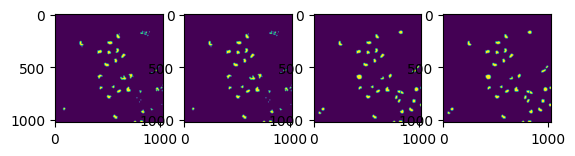

Epoch  150 Training loss:  0.19636693000793456 IoU score:  0.0 Time:  1.6856000423431396
Epoch  151 Training loss:  0.196354877948761 IoU score:  0.0 Time:  1.3519461154937744
Epoch  152 Training loss:  0.1963539481163025 IoU score:  0.0 Time:  1.384606122970581
Epoch  153 Training loss:  0.19634053707122803 IoU score:  0.0 Time:  1.3464546203613281
Epoch  154 Training loss:  0.1963359832763672 IoU score:  0.0 Time:  1.3388996124267578
Epoch  155 Training loss:  0.19632568359375 IoU score:  0.0 Time:  1.3231840133666992
Epoch  156 Training loss:  0.19631822109222413 IoU score:  0.0 Time:  1.283001184463501
Epoch  157 Training loss:  0.1963182806968689 IoU score:  0.0 Time:  1.3071422576904297
Epoch  158 Training loss:  0.1963129997253418 IoU score:  0.0 Time:  1.3111708164215088
Epoch  159 Training loss:  0.19628843069076538 IoU score:  0.0 Time:  1.3712961673736572


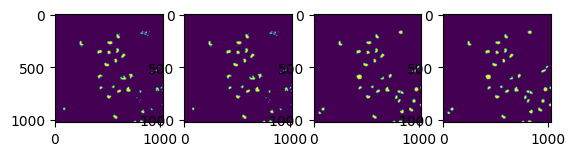

Epoch  160 Training loss:  0.196281099319458 IoU score:  0.0 Time:  1.5765047073364258
Epoch  161 Training loss:  0.1962744951248169 IoU score:  0.0 Time:  1.3355638980865479
Epoch  162 Training loss:  0.1962753415107727 IoU score:  0.0 Time:  1.3516061305999756
Epoch  163 Training loss:  0.19626592397689818 IoU score:  0.0 Time:  1.355006456375122
Epoch  164 Training loss:  0.19625788927078247 IoU score:  0.0 Time:  1.4144947528839111
Epoch  165 Training loss:  0.19627177715301514 IoU score:  0.0 Time:  1.2986657619476318
Epoch  166 Training loss:  0.19624429941177368 IoU score:  0.0 Time:  1.3868684768676758


In [ ]:
step = 2
loss_fn = LF_two()

#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.0001, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.00001, max_lr=0.0001)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step,device='cuda:0')

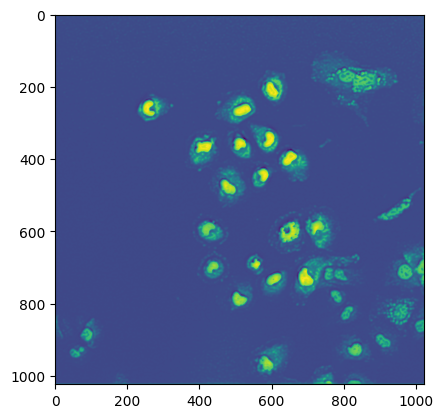

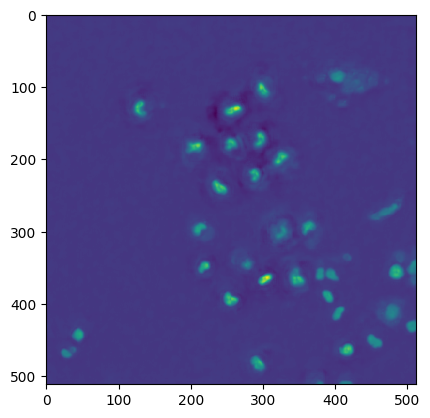

In [ ]:
#make a prediction and let's apply modifications

def make_pred(unet, image):
    image = image.unsqueeze(0).unsqueeze(0)
    image = image.to('cuda:0')
    y_16_pred, y_32_pred, y_3_pred = unet(image)
    y_32_pred = y_32_pred.squeeze(0)
    y_3_pred = y_3_pred.squeeze(0)
    y_3_pred = y_3_pred.cpu().detach().numpy()[0]
    return y_3_pred

image = test_images[0]
y_3_pred = make_pred(unet, image)

plt.imshow(y_3_pred)
plt.show()
plt.imshow(test_cellprob[0])
plt.show()

In [ ]:
print(1/(1+np.exp(-y_3_pred)))

[[3.7452042e-02 7.0178602e-03 4.0167989e-03 ... 3.3095255e-03
  5.1450953e-03 2.6370173e-02]
 [7.6496913e-03 5.9263961e-04 2.6556733e-04 ... 2.0178474e-04
  3.9448857e-04 5.6556645e-03]
 [5.8174767e-03 4.1126096e-04 1.8975578e-04 ... 1.5369982e-04
  2.8266993e-04 4.5582186e-03]
 ...
 [4.9159769e-03 2.7325284e-04 9.0897774e-05 ... 8.7848290e-05
  2.0780123e-04 4.1271639e-03]
 [8.2258247e-03 6.8107474e-04 2.7683802e-04 ... 2.6732427e-04
  5.4451864e-04 7.4583027e-03]
 [3.7217747e-02 8.7196529e-03 5.2912631e-03 ... 5.2062236e-03
  8.0172373e-03 4.1619029e-02]]


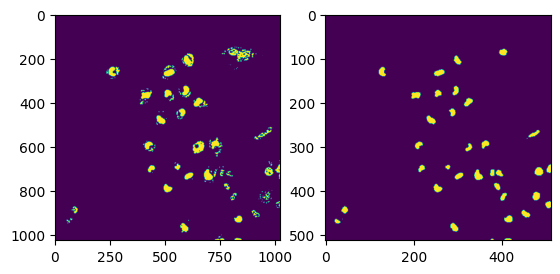

In [ ]:
pred = y_3_pred
#put pred through a sigmoid function
pred = 1/(1+np.exp(-pred))
pred = pred > 0.5

gt = test_cellprob[0]
gt = gt > 0.5

plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(gt)
plt.show()

In [ ]:
#let's calculate the class difference

#get the groundtruth mask
gt_mask = test_cellprob[0]
gt_mask = gt_mask > 0.5

#get the groundtruth cellprob
gt_cp = test_cellprob[0]
gt_cp = F.sigmoid(gt_cp)

#get all the gt_cp values that are 1
gt_cp_0 = gt_cp[gt_mask == 0]
gt_cp_1 = gt_cp[gt_mask == 1]

#get the mean value of gt_cp_0
gt_cp_0_mean = gt_cp_0.mean()
gt_cp_1_mean = gt_cp_1.mean()

pred = y_3_pred
pred = np.resize(pred, (512,512))
#sigmoid the pred
pred = F.sigmoid(torch.from_numpy(pred))
pred_0 = pred[gt_mask == 0]
pred_1 = pred[gt_mask == 1]
pred_0_mean = pred_0.mean()
pred_1_mean = pred_1.mean()

#absolute difference between the contrasts
print(abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean))

tensor(0.0031, dtype=torch.float64)
tensor(0.9575, dtype=torch.float64)
tensor(-0.9543, dtype=torch.float64)
tensor(0.4707)
tensor(0.4707)
tensor(-4.6015e-05)
tensor(0.9543, dtype=torch.float64)


c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(gt.unsqueeze(0).shape)
mask0 = gt[:, 0].unsqueeze(1)
mask1 = gt[:, 1].unsqueeze(1)

torch.Size([1, 512, 512])


In [ ]:
print(np.unique(mask0))
print(np.unique(mask1))


[False]
[False]


In [ ]:
print(test_cellprob[0])

tensor([[-8.2197, -8.0311, -7.9962,  ..., -7.6628, -7.7984, -7.9332],
        [-8.1718, -8.4967, -8.1357,  ..., -7.6183, -7.8410, -8.0483],
        [-8.1877, -8.8362, -8.4895,  ..., -7.8520, -8.0727, -8.2621],
        ...,
        [-8.1536, -8.7004, -7.9286,  ..., -8.0617, -8.0611, -8.4182],
        [-8.1920, -8.6453, -7.8699,  ..., -7.9053, -8.0869, -8.2721],
        [-7.9803, -8.5260, -8.5515,  ..., -8.3653, -8.5924, -8.5442]],
       dtype=torch.float64)
